# WWW: West Coast Wildfires and Weather
### Tutorial: Analysis of Wildfire and Weather Data

Mark Keller<br>
CMSC320<br>
Final Tutorial Project<br>
29 November 2018

#### Table of Contents
1. [Introduction](#1.-Introduction)
2. [Data](#2.-Data)<br>
    2.1 [West Coast Wildfire Data](#2.1-West-Coast-Wildfire-Data)<br>
    2.2 [Supplementary Weather Data](#2.2-Supplementary-Weather-Data)<br>
    2.3 [Merging the data](#2.3-Merging-the-data)
3. [Exploration](#3.-Exploration)<br>
    3.1 [Univariate Analysis](#3.1-Univariate-Analysis)<br>
    3.2 [Multivariate Analysis](#3.2-Multivariate-Analysis)
4. [Hypothesis Testing](#4.-Hypothesis-Testing)
5. [Classification and Multiple Regression](#5.-Classification-and-Multiple-Regression)
6. [Conclusions](#6.-Conclusions)


## 1. Introduction

For the past few weeks, the Camp Fire in Northern California has been a deadly and destructive force, recieving enormous media coverage. 
This deadly wildfire that began on November 8, 2018 has left [85 people dead, 249 missing, and destroyed thousands of buildings](https://www.usatoday.com/story/news/nation/2018/11/25/california-wildfire-camp-fire-contained/2107829002/).
It has resulted in major air quality issues, causing many to [wear masks](https://www.washingtonpost.com/nation/2018/11/17/behold-latest-sign-apocalypse-air-mask-selfies-fire-ravaged-california/?utm_term=.fe6d94c1991f) or [stay indoors](https://www.wired.com/story/smoke-from-wildfires-is-a-growing-public-health-crisis-for-cities/) to protect their health.
But this is not the first time a major wildfire has ravaged the west coast of the United States.

In this tutorial, we will analyze west coast wildfire data from 2010 to 2016, available through the University of California Irvine Data Science Initiative GitHub organization [here](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/tree/master/west_coast_fires). This data has been obtained through the NASA [Moderate Resolution Imaging Spectroradiometer](https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer) (MODIS) satellite. We will merge this wildfire data with daily weather data obtained from NOAA Climate Data Online tool.

We will begin by loading the data and performing exploratory data analysis before diving deeper into regression analysis and classification analysis using basic machine learning methods. These data science methods will allow us to look at past trends and make inferences about future west coast wildfires.

<img src="img/stelprdb5173318.jpg" alt="Wildfire Prevention" width="300"/>

## 2. Data

We will begin by importing Python packages that will help us to load and wrangle the data:
- [pandas](https://pandas.pydata.org/pandas-docs/stable/#): a package that allows us to build data frames, a tabular data format that can be thought of like a spreadsheet
- [numpy](https://docs.scipy.org/doc/numpy/user/quickstart.html): a package containing a multi-dimensional array implementation and vectorized mathematical functions

In [1]:
import pandas as pd
import numpy as np

### 2.1 West Coast Wildfire Data
The wildfire dataset is contained in a comma-separated values file (CSV) located on GitHub. Pandas has a `read_csv` function that allows us to load a data frame from a CSV over the web. We will specify the data types of each column using a python `dict` to ensure that pandas loads the data using the data types that we will want to use in our analysis.

In [2]:
data_url = 'https://raw.githubusercontent.com/UCIDataScienceInitiative/Climate_Hackathon/master/west_coast_fires/fires.csv'
dtype = {
    'confidence': float,
    'day': int,
    'frp': float,
    'lat': float,
    'lon': float,
    'month': int,
    'year': int,
    'x': float,
    'y': float,
    'dayofyear': int,
    'vdp': float,
    'temp': float,
    'humidity': float
}
df = pd.read_csv(data_url, dtype=dtype)
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0  10122        0.61    1   6.0  32.997 -110.765      1  2010  1336.853783   
1  10123        0.72    1  11.1  32.995 -110.777      1  2010  1335.747633   
2  13460        0.57    2   6.3  33.650 -113.735      1  2010  1056.936097   
3  13461        0.62    2  10.2  32.358 -114.922      1  2010   950.464277   
4  22139        0.56    3  14.4  33.415 -110.860      1  2010  1325.030866   

         y  dayofyear       vpd    temp  humidity  
0  110.667          0  0.232254  271.10      55.8  
1  110.445          0  0.232254  271.10      55.8  
2  183.150          1  0.333371  272.70      43.6  
3   39.738          1  0.158511  274.70      76.8  
4  157.065          2  0.159304  268.62      63.5

We can use the `shape` variable to learn how many fire observations are contained in this dataset:

In [3]:
df.shape

(216232, 14)

The next step is to determine what this wildfire data means so that we can perform exploration. 
Luckily, the [README](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/blob/master/west_coast_fires/README.md) for the GitHub repository provides us with a description of each column:

- `id`: unique identifier of the fire in the overall context of the world dataset
- `confidence`: how much confidence the satellite has that this is actually a fire detection (percent)
- `day`: the day of the month
- `frp`: Fire Radiative Power, the strength of the fire
- `lat`: latitude
- `lon`: longitude
- `month`: month of the year
- `year`: year
- `x`: x position in a uniformly-spaced grid
- `y`: y position in a uniformly-spaced grid
- `dayofyear`: day of the year (from 0 to 364 or 365 for leap years)
- `vpd`: [Vapor Pressure Deficit](https://en.wikipedia.org/wiki/Vapour-pressure_deficit), the difference between the moisture in the air and the amount of moisture the air could hold
- `temp`: temperature (degrees Kelvin)
- `humidity`: humidity (percent)


To be extra cautious, we can restrict our analysis to those fires with high confidence.

In [4]:
confidence_threshold = 0.8
df = df.loc[df['confidence'] > confidence_threshold]

We can observe the size of our data after filtering by `confidence` threshold.

In [5]:
df.shape

(97016, 14)

We will also want to exclude fires with a strength of zero.

In [6]:
frp_threshold = 1
df = df.loc[df['frp'] > frp_threshold]

We can again observe the size of our data, this time after filtering by `frp` threshold.

In [7]:
df.shape

(96821, 14)

The wildfire dataset README notes that the same fire may be split into separate observations if it spreads over multiple locations or last multiple days. We can try to remedy this by consolidating fire observations which:
- are close together
- span multiple consecutive days.

According to [the Wildfire page on Wikipedia](https://en.wikipedia.org/wiki/Wildfire#Physical_properties), forest fires can spread as fast as 10.8 km per hour. Using this information, we can consider that in a single day, it is possible that a fire could spread approximately 259 kilometers:

In [8]:
wildfire_max_daily_spread = 10.8*24
wildfire_max_daily_spread

259.20000000000005

To easily identify consecutive days, we will first add a column called `dayofdataset` which is similar to `dayofyear` but does not restart at the end of the year.

In [9]:
min_year = df['year'].min()
max_year = df['year'].max()
df['dayofdataset'] = df.apply(lambda row: (row['year'] - min_year) * 365 + row['dayofyear'], axis='columns')

Next we will take the difference of `dayofdataset` for each each row with the previous row. The resulting groups of rows that are 1 day or 0 days apart will be the candidates for our consolidation procedure.

In [10]:
df['dayofdataset_diff'] = df['dayofdataset'].diff()
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
6    40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
22   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
40  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
41  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
42  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

          y  dayofyear       vpd    temp  humidity  dayofdataset  \
6   157.398          3  0.290486  270.57      42.5           3.0   
22  264.957          4  0.233602  266.02      34.7           4.0   
40  344.211          7  0.157593  261.97      39.4           7.0   
41  345.321          7  0.157593  261.97      39.4           7.0   
42  345.099          7  0.157593  261.97      39.4           7.0   

    dayofdataset_diff  
6                 NaN  
22                1.0  
40                3.0  
41                0.0  
42                0.0

Based on this date difference column, we can give each group of consecutive dates a different index, so that we can use `groupby` to iterate over each group of dates.

In [11]:
df = df.reset_index(drop=True)
df['date_group_index'] = np.nan
curr_date_group_index = 1
for index, row in df.iterrows():
    if pd.isna(row['dayofdataset_diff']) or row['dayofdataset_diff'] <= 1.0:
        df.at[index, 'date_group_index'] = curr_date_group_index
    else:
        # Change the date group index when the current day 
        # is over one day past the day of the previous fire observation
        curr_date_group_index += 1
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y  dayofyear       vpd    temp  humidity  dayofdataset  \
0  157.398          3  0.290486  270.57      42.5           3.0   
1  264.957          4  0.233602  266.02      34.7           4.0   
2  344.211          7  0.157593  261.97      39.4           7.0   
3  345.321          7  0.157593  261.97      39.4           7.0   
4  345.099          7  0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index  
0                NaN               1.0  
1                1.0               1.0  
2                3.0               NaN  
3                0.0               2.0  
4                0.0               2.0

After grouping fires by date, the next step is to group the fires in a specific date group by location.

Our first thought might be to do pairwise comparison of distances between fires, using something like the [Haversine Formula](https://en.wikipedia.org/wiki/Haversine_formula) which computes distances between locations using their latitude and longitude values. 

In [12]:
# Adapted from this StackOverflow post: https://stackoverflow.com/a/4913653
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # radius of earth in kilometers
    return c * r

However, the size of our largest "date group" is over 20,000 rows:

In [13]:
max([date_group_df.shape[0] for date_group_index, date_group_df in df.groupby(['date_group_index'])])

23155

so the number of pairwise comparisons we would need to perform is _massive_:
$$ {23155 \choose 2} = 268065435 $$

We will need to be more clever. Perhaps a recently-open-sourced tool by Uber called [h3](https://uber.github.io/h3/#/) (and its python bindings at [h3-py](https://github.com/uber/h3-py)) can help us. 

In [14]:
from h3 import h3

`h3` is a "hierarchical hexagonal geospatial indexing system" and divides a geograpical space into hexagons, which have nice properties including approximating circles:

<img src="img/parent-child.png" alt="h3" width="300"/>

We can use the h3 [table of resolutions](https://uber.github.io/h3/#/documentation/core-library/resolution-table) to determine the size of hexagon that will best suit our needs. Considering the maximum wildfire spread per day is 259 km, and a circle with radius $\frac {259}{2}$ has the following area:

In [15]:
np.pi*(259/2)**2

52685.29419886423

We will choose resolution 3, because the area of resolution 2 is too large, so 3 is the closest match without going over.

Resolution 3 has the following properties:

| Average Hexagon Area (km2) | Average Hexagon Edge Length (km) | Number of unique indexes |
|----------------------------|----------------------------------|--------------------------|
| 12,392.2648621 | 59.810857940 | 41,162 |

In [16]:
h3_resolution = 3

Now we can assign each fire to a hexagon at this resolution:

In [17]:
def get_h3_address(row):
    return h3.geo_to_h3(row['lat'], row['lon'], h3_resolution)

df['h3_address'] = df.apply(get_h3_address, axis='columns')
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y  dayofyear       vpd    temp  humidity  dayofdataset  \
0  157.398          3  0.290486  270.57      42.5           3.0   
1  264.957          4  0.233602  266.02      34.7           4.0   
2  344.211          7  0.157593  261.97      39.4           7.0   
3  345.321          7  0.157593  261.97      39.4           7.0   
4  345.099          7  0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index       h3_address  
0                NaN               1.0  8348ebfffffffff  
1                1.0               1.0  8348cdfffffffff  
2                3.0               NaN  8329b2fffffffff  
3                0.0               2.0  8329b2fffffffff  
4                0.0               2.0  8329b2fffffffff

We will use the h3 `k_ring` functionality to return the set of hexagons neighboring a given hexagon address:
<img src="img/neighbors.png" alt="h3" width="300"/>

In [18]:
h3.k_ring("8348ebfffffffff", 1) # demonstrating the k_ring function

{'8329b6fffffffff',
 '8348ccfffffffff',
 '8348cdfffffffff',
 '8348e8fffffffff',
 '8348e9fffffffff',
 '8348eafffffffff',
 '8348ebfffffffff'}

We will do this for all fires in each "date group" and assign a new "fire group" index to those fires within one hexagon of each other:

In [19]:
curr_max_fire_group_index = df.shape[0]
df['fire_group_index'] = np.arange(curr_max_fire_group_index)

# Iterate over every "date group"
for date_group_index, date_group_df in df.groupby(['date_group_index']):
    # Get the set of all unique hexagon addresses for this date group
    date_group_h3_address_set = set(date_group_df['h3_address'].unique())
    # While the set of addresses is not empty compute fire groups
    while len(date_group_h3_address_set) > 0:
        # Pop a hexagon address from the set
        h3_address = date_group_h3_address_set.pop()
        # Get the addresses of the neighboring hexagons
        h3_address_k_ring_set = h3.k_ring(h3_address, 1)
        # Get all observations in this date group which are in this hexagon or the neighboring hexagons
        h3_address_k_ring_set_df = date_group_df.loc[date_group_df['h3_address'].isin(h3_address_k_ring_set)]
        # Assign these observations to the same "fire group" unless they are over a day apart
        curr_max_fire_group_index += 1
        curr_date = h3_address_k_ring_set_df.reset_index(drop=True).loc[0]['dayofdataset']
        for fire_index_in_group in list(h3_address_k_ring_set_df.index.values):
            fire_date = df.at[fire_index_in_group, 'dayofdataset']
            if fire_date - curr_date > 1:
                curr_max_fire_group_index += 1
            curr_date = fire_date
            df.at[fire_index_in_group, 'fire_group_index'] = curr_max_fire_group_index
        date_group_h3_address_set = (date_group_h3_address_set - h3_address_k_ring_set)

df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y  dayofyear       vpd    temp  humidity  dayofdataset  \
0  157.398          3  0.290486  270.57      42.5           3.0   
1  264.957          4  0.233602  266.02      34.7           4.0   
2  344.211          7  0.157593  261.97      39.4           7.0   
3  345.321          7  0.157593  261.97      39.4           7.0   
4  345.099          7  0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index       h3_address  fire_group_index  
0                NaN               1.0  8348ebfffffffff             96822  
1                1.0               1.0  8348cdfffffffff             96822  
2                3.0               NaN  8329b2fffffffff                 2  
3                0.0               2.0  8329b2fffffffff             96823  
4                0.0               2.0  8329b2fffffffff             96823

Later we will be able to use the `fire_group_index` column to identify our groups of fire observations as single fires.

### 2.2 Supplementary Weather Data
Using the NOAA [Climate Data Online (CDO)](https://www.ncdc.noaa.gov/cdo-web/search) service, we can obtain daily climate data from 2010 to 2016, from weather stations in the west coast. The CDO search tool allows us to select NOAA stations of interest and the types of data we want to download for a specified time period.  In this case, I have manually selected 75 [weather stations](https://www.ncdc.noaa.gov/cdo-web/datatools/findstation) spread throughout the west coast region. 

Along with the location (latitude and longitude) of each weather station, I selected to download data comprising the following variables:

__Air Temperature__<br>
- `TAVG`: Average Temperature
- `TMAX`: Maximum temperature
- `TMIN`: Minimum temperature

__Precipitation__<br>
- `MDPR`: Multiday precipitation total (use with DAPR and DWPR, if available)
- `DAPR`: Number of days included in the multiday precipitation total (MDPR)
- `PRCP`: Precipitation
- `SNWD`: Snow depth
- `SNOW`: Snowfall

__Sunshine__<br>
- `PSUN`: Daily percent of possible sunshine for the period
- `TSUN`: Total sunshine for the period

__Wind__<br>
- `AWND`: Average wind speed
- `WDF2`: Direction of fastest 2-minute wind
- `WDF5`: Direction of fastest 5-second wind 
- `WSF2`: Fastest 2-minute wind speed
- `WSF5`: Fastest 5-second wind speed
- `PGTM`: Peak gust time
- `FMTM`: Time of fastest mile or fastest 1-minute wind

__Weather Type__: binary indication of specific weather events<br>
- `WT01`: Fog, ice fog, or freezing fog (may include heavy fog)
- `WT02`: Heavy fog or heaving freezing fog (not always distinguished from fog)
- `WT03`: Thunder
- `WT04`: Ice pellets, sleet, snow pellets, or small hail
- `WT05`: Hail (may include small hail)
- `WT06`: Glaze or rime 
- `WT07`: Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
- `WT08`: Smoke or haze
- `WT09`: Blowing or drifting snow
- `WT10`: Tornado, waterspout, or funnel cloud
- `WT11`: High or damaging winds
- `WT13`: Mist
- `WT14`: Drizzle
- `WT15`: Freezing drizzle
- `WT16`: Rain (may include freezing rain, drizzle, and freezing drizzle)
- `WT17`: Freezing rain
- `WT18`: Snow, snow pellets, snow grains, or ice crystals
- `WT19`: Unknown source of precipitation
- `WT21`: Ground fog 
- `WT22`: Ice fog or freezing fog

After selecting data, the CDO tool sends an email with our requested data to download. I have done this and place the downloaded file in this GitHub repository so that we can easily load it with `pandas`.

In [20]:
cdo_df = pd.read_csv('data/1572799.csv')
cdo_df.head()

STATION                             NAME  LATITUDE  LONGITUDE  \
0  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
1  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
2  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
3  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
4  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   

   ELEVATION        DATE   AWND  DAPR    FMTM  MDPR  ...   WT11  WT13  WT14  \
0     1266.1  2010-01-01  13.65   NaN  1009.0   NaN  ...    NaN   1.0   NaN   
1     1266.1  2010-01-02   9.84   NaN   206.0   NaN  ...    NaN   1.0   NaN   
2     1266.1  2010-01-03   5.59   NaN  2359.0   NaN  ...    NaN   NaN   NaN   
3     1266.1  2010-01-04    NaN   NaN   228.0   NaN  ...    NaN   NaN   NaN   
4     1266.1  2010-01-05    NaN   NaN  2340.0   NaN  ...    NaN   NaN   NaN   

   WT15  WT16  WT17  WT18  WT19  WT21  WT22  
0   NaN   1.0   NaN   1.0   1.0   NaN   NaN  
1   NaN   1.0   NaN   1.0   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 44 columns]

And taking note of the size of this data frame:

In [21]:
cdo_df.shape

(188890, 44)

### 2.3 Merging the data

To be able to match this weather data with our wildfire data, we will look at the weather from the closest station to each fire observation. 

We will first need to map each station to its location.

In [22]:
cdo_loc_df = cdo_df.drop_duplicates(subset=['STATION'])[['STATION', 'LATITUDE', 'LONGITUDE']].set_index('STATION', drop=True)
cdo_loc_df.head()

LATITUDE  LONGITUDE
STATION                         
USW00024133   42.5416 -113.76610
USW00024131   43.5666 -116.24050
USW00093075   38.7500 -109.76278
USW00024132   45.7880 -111.16080
USW00093230   38.8983 -119.99470

Using the `haversine` formula from above, we can write a function that returns the ID of the closest weather station and the distance (in kilometers), given the coordinates of a fire:

In [23]:
def get_closest_station(fire_lon, fire_lat):
    station_distance_series = cdo_loc_df.apply(lambda row: haversine(row['LONGITUDE'], row['LATITUDE'], fire_lon, fire_lat), axis='columns')
    return (station_distance_series.idxmin(), station_distance_series.min())

Now we can apply this function along the entire wildfire dataframe, creating two new columns:

In [24]:
df['closest_station'], df['closest_station_dist'] = zip(*df.apply(lambda row: get_closest_station(row['lon'], row['lat']), axis='columns'))
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y         ...                vpd    temp  humidity  dayofdataset  \
0  157.398         ...           0.290486  270.57      42.5           3.0   
1  264.957         ...           0.233602  266.02      34.7           4.0   
2  344.211         ...           0.157593  261.97      39.4           7.0   
3  345.321         ...           0.157593  261.97      39.4           7.0   
4  345.099         ...           0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index       h3_address fire_group_index  \
0                NaN               1.0  8348ebfffffffff            96822   
1                1.0               1.0  8348cdfffffffff            96822   
2                3.0               NaN  8329b2fffffffff                2   
3                0.0               2.0  8329b2fffffffff            96823   
4                0.0               2.0  8329b2fffffffff            96823   

   closest_station closest_station_dist  
0      USW00023183           105.971337  
1      USW00003103            84.972498  
2      USW00003103            39.102676  
3      USW00003103            39.160723  
4      USW00003103            40.449813  

[5 rows x 21 columns]

The mean distance from fires to the closest weather station is approximately 79 kilometers, or 49 miles:

In [25]:
df['closest_station_dist'].mean()

78.8566412646424

Turning our attention to the weather dataframe now, we will convert its date values into a `dayofyear` column so that we can easily cross-reference from the wildfire dataset to determine the weather on the day of a fire.

We will need to import python's `datetime` to help with date formatting.

In [73]:
import datetime

In [27]:
def cdo_date_to_dayofyear(cdo_date):
    date = datetime.datetime.fromisoformat(cdo_date).date()
    return int(date.strftime('%-j'))

def cdo_date_to_year(cdo_date):
    date = datetime.datetime.fromisoformat(cdo_date).date()
    return int(date.strftime('%Y'))

Now we can apply this conversion function to all of the date values in the CDO weather dataset:

In [28]:
cdo_df['dayofyear'] = cdo_df['DATE'].apply(cdo_date_to_dayofyear)
cdo_df['year'] = cdo_df['DATE'].apply(cdo_date_to_year)
cdo_df['dayofdataset'] = cdo_df.apply(lambda row: (row['year'] - min_year) * 365 + row['dayofyear'], axis='columns')

Next, we can compute periods of drought.

We can perform a similar process as we did before when computing groups of dates for the wildfires, and assign unique indices to groups of consecutive observations (from the same weather station) with zero values for the `PRCP` precipitation column.

In [29]:
cdo_df['drought_group_index'] = np.nan
curr_drought_index = 1

# For each station, compute periods of drought separately
for station_name, station_df in cdo_df.groupby(['STATION']):
    # Assign a drought group index to each observation
    for index, row in station_df.iterrows():
        if pd.isna(row['PRCP']) or row['PRCP'] == 0.0:
            cdo_df.at[index, 'drought_group_index'] = curr_drought_index
        else:
            # Change the index value if precipitation occurs to signify an end to the current drought
            # but do not assign a drought index to this value, keep as NaN
            curr_drought_index += 1
cdo_df.head()

STATION                             NAME  LATITUDE  LONGITUDE  \
0  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
1  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
2  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
3  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
4  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   

   ELEVATION        DATE   AWND  DAPR    FMTM  MDPR         ...           \
0     1266.1  2010-01-01  13.65   NaN  1009.0   NaN         ...            
1     1266.1  2010-01-02   9.84   NaN   206.0   NaN         ...            
2     1266.1  2010-01-03   5.59   NaN  2359.0   NaN         ...            
3     1266.1  2010-01-04    NaN   NaN   228.0   NaN         ...            
4     1266.1  2010-01-05    NaN   NaN  2340.0   NaN         ...            

   WT16  WT17  WT18  WT19  WT21  WT22  dayofyear  year  dayofdataset  \
0   1.0   NaN   1.0   1.0   NaN   NaN          1  2010             1   
1   1.0   NaN   1.0   NaN   NaN   NaN          2  2010             2   
2   NaN   NaN   NaN   NaN   NaN   NaN          3  2010             3   
3   NaN   NaN   NaN   NaN   NaN   NaN          4  2010             4   
4   NaN   NaN   NaN   NaN   NaN   NaN          5  2010             5   

   drought_group_index  
0                  NaN  
1                  NaN  
2              14041.0  
3              14041.0  
4              14041.0  

[5 rows x 48 columns]

We can create a new dataframe containing the start day, end day, and length of each drought period:

In [30]:
drought_df = pd.DataFrame(data=[], index=[], columns=['STATION', 'drought_group_index', 'dayofdataset_start', 'dayofdataset_end', 'length'])

# For each drought group, append a single drought observation to the drought dataframe
for drought_group_index, drought_group_df in cdo_df.groupby(['drought_group_index']):
    if pd.notnull(drought_group_index):
        # Compute aggregate drought data
        drought_group_df_index_vals = list(drought_group_df.index.values)
        drought_group_start_day = drought_group_df.loc[drought_group_df_index_vals[0]]['dayofdataset']
        drought_group_end_day = drought_group_df.loc[drought_group_df_index_vals[-1]]['dayofdataset']
        drought_group_length = (drought_group_end_day - drought_group_start_day)
        drought_group_station = drought_group_df.loc[drought_group_df_index_vals[0]]['STATION']
        if drought_group_length > 0:
            # Append the row representing one drought period
            drought_df = drought_df.append({
                'STATION': drought_group_station,
                'drought_group_index': drought_group_index,
                'dayofdataset_start': drought_group_start_day,
                'dayofdataset_end': drought_group_end_day,
                'length': drought_group_length
            }, ignore_index=True)

drought_df.head()

STATION  drought_group_index dayofdataset_start dayofdataset_end length
0  USC00425654                  1.0                  1               13     12
1  USC00425654                  2.0                 15               19      4
2  USC00425654                  4.0                 23               26      3
3  USC00425654                  6.0                 29               36      7
4  USC00425654                  8.0                 39               50     11

Finally we are ready to merge our drought data with our fire data. We will add a new column to indicate how long of a drought (if any) preceded the fire. 

In [31]:
def get_drought_length(row):
    fire_drought_df = drought_df.loc[
        (drought_df['STATION'] == row['closest_station']) & 
        (drought_df['dayofdataset_start'] <= row['dayofdataset']) &
        (drought_df['dayofdataset_end'] >= row['dayofdataset'])
    ]
    if fire_drought_df.shape[0] == 1:
        return (row['dayofdataset'] - fire_drought_df.reset_index(drop=True).loc[0]['dayofdataset_start'])
    else:
        return 0

df['drought_length'] = df.apply(get_drought_length, axis='columns')
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y      ...          temp  humidity  dayofdataset  dayofdataset_diff  \
0  157.398      ...        270.57      42.5           3.0                NaN   
1  264.957      ...        266.02      34.7           4.0                1.0   
2  344.211      ...        261.97      39.4           7.0                3.0   
3  345.321      ...        261.97      39.4           7.0                0.0   
4  345.099      ...        261.97      39.4           7.0                0.0   

   date_group_index       h3_address  fire_group_index closest_station  \
0               1.0  8348ebfffffffff             96822     USW00023183   
1               1.0  8348cdfffffffff             96822     USW00003103   
2               NaN  8329b2fffffffff                 2     USW00003103   
3               2.0  8329b2fffffffff             96823     USW00003103   
4               2.0  8329b2fffffffff             96823     USW00003103   

   closest_station_dist drought_length  
0            105.971337            2.0  
1             84.972498            3.0  
2             39.102676            6.0  
3             39.160723            6.0  
4             40.449813            6.0  

[5 rows x 22 columns]

Next we can merge wind, sun, and weather type data with each fire observation. Perhaps fires are stronger or last longer during periods with high wind speed. Or fires may be more likely occur on days with thunder (since it implies lightning).

In [32]:
def get_weather_during_fire(row):
    weather_during_fire_df = cdo_df.loc[
        (cdo_df['STATION'] == row['closest_station']) & 
        (cdo_df['dayofdataset'] == row['dayofdataset'])
    ]
    weather_dict = {
        # Temp
        'TAVG': np.nan,
        'TMIN': np.nan,
        'TMAX': np.nan,
        # Sun
        'PSUN': np.nan,
        'TSUN': np.nan,
        # Wind
        'AWND': np.nan,
        'WSF2': np.nan,
        'WSF5': np.nan,
        # Weather type
        'WT03': np.nan,
        'WT07': np.nan,
        'WT08': np.nan,
        'WT11': np.nan,
        'WT16': np.nan
    }
    if weather_during_fire_df.shape[0] == 1:
        weather_row = weather_during_fire_df.reset_index(drop=True).loc[0]
        for weather_dict_key in weather_dict.keys():
            weather_dict[weather_dict_key] = weather_row[weather_dict_key]
    
    return pd.Series(list(weather_dict.values()), index=list(weather_dict.keys()))
    

matched_weather_df = df.apply(get_weather_during_fire, axis='columns')
for matched_weather_column in list(matched_weather_df.columns.values):
    df[matched_weather_column] = matched_weather_df[matched_weather_column]
    
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y ...   PSUN  TSUN  AWND  WSF2  WSF5  WT03  WT07 WT08  WT11 WT16  
0  157.398 ...    NaN   NaN  2.24  10.1  13.0   NaN   NaN  NaN   NaN  NaN  
1  264.957 ...    NaN   NaN  4.92  15.0  21.0   NaN   NaN  NaN   NaN  NaN  
2  344.211 ...    NaN   NaN  3.58  14.1  16.1   NaN   NaN  NaN   NaN  NaN  
3  345.321 ...    NaN   NaN  3.58  14.1  16.1   NaN   NaN  NaN   NaN  NaN  
4  345.099 ...    NaN   NaN  3.58  14.1  16.1   NaN   NaN  NaN   NaN  NaN  

[5 rows x 35 columns]

Using the "fire groups" we can create a new dataset containing one observation for each group:

In [33]:
grouped_df_columns = [
    'fire_group_index',
    'fire_group_size',
    'day_start',
    'day_end',
    'frp_mean',
    'frp_sum',
    'lat_min',
    'lat_max',
    'lon_min',
    'lon_max',
    'month_start',
    'month_end',
    'year_start',
    'year_end',
    'dayofyear_start',
    'dayofyear_end',
    'dayofdataset_start',
    'dayofdataset_end',
    'x_min',
    'x_max',
    'y_min',
    'y_max',
    'vpd_mean',
    'temp_mean',
    'humidity_mean',
    'drought_length',
    # Temp
    'TAVG_mean',
    'TMIN_min',
    'TMAX_max',
    # Sun
    'PSUN_mean',
    'TSUN_mean',
    # Wind
    'AWND_mean',
    'AWND_min',
    'AWND_max',
    'WSF2_mean',
    'WSF2_min',
    'WSF2_max',
    'WSF5_mean',
    'WSF5_min',
    'WSF5_max',
    # Weather type
    'WT03_sum',
    'WT07_sum',
    'WT08_sum',
    'WT11_sum',
    'WT16_sum'
]
grouped_df = pd.DataFrame(data=[], index=[], columns=grouped_df_columns)

# Append a single row for each "fire group"
for fire_group_index, fire_group_df in df.groupby(['fire_group_index']):
    fire_group_df = fire_group_df.reset_index(drop=True)
    start_row = fire_group_df.loc[0]
    end_row = fire_group_df.loc[fire_group_df.shape[0]-1]
    grouped_df = grouped_df.append({
        'fire_group_index': fire_group_index,
        'fire_group_size': fire_group_df.shape[0],
        'day_start': start_row['day'],
        'day_end': end_row['day'],
        'frp_mean': fire_group_df['frp'].mean(),
        'frp_sum': fire_group_df['frp'].sum(),
        'lat_min': fire_group_df['lat'].min(),
        'lat_max': fire_group_df['lat'].max(),
        'lon_min': fire_group_df['lon'].min(),
        'lon_max': fire_group_df['lon'].max(),
        'month_start': start_row['month'],
        'month_end': end_row['month'],
        'year_start': start_row['year'],
        'year_end': end_row['year'],
        'dayofyear_start': start_row['dayofyear'],
        'dayofyear_end': end_row['dayofyear'],
        'dayofdataset_start': start_row['dayofdataset'],
        'dayofdataset_end': end_row['dayofdataset'],
        'x_min': fire_group_df['x'].min(),
        'x_max': fire_group_df['x'].max(),
        'y_min': fire_group_df['y'].min(),
        'y_max': fire_group_df['y'].max(),
        'vpd_mean': fire_group_df['vpd'].mean(),
        'temp_mean': fire_group_df['temp'].mean(),
        'humidity_mean': fire_group_df['humidity'].mean(),
        'drought_length': start_row['drought_length'],
        # Temp
        'TAVG_mean': fire_group_df['TAVG'].mean(),
        'TMIN_min': fire_group_df['TMIN'].min(),
        'TMAX_max': fire_group_df['TMAX'].max(),
        # Sun
        'PSUN_mean': fire_group_df['PSUN'].mean(),
        'TSUN_mean': fire_group_df['TSUN'].mean(),
        # Wind
        'AWND_mean': fire_group_df['AWND'].mean(),
        'AWND_min': fire_group_df['AWND'].min(),
        'AWND_max': fire_group_df['AWND'].max(),
        'WSF2_mean': fire_group_df['WSF2'].mean(),
        'WSF2_min': fire_group_df['WSF2'].min(),
        'WSF2_max': fire_group_df['WSF2'].max(),
        'WSF5_mean': fire_group_df['WSF5'].mean(),
        'WSF5_min': fire_group_df['WSF5'].min(),
        'WSF5_max': fire_group_df['WSF5'].max(),
        # Weather type
        'WT03_sum': fire_group_df['WT03'].sum(),
        'WT07_sum': fire_group_df['WT07'].sum(),
        'WT08_sum': fire_group_df['WT08'].sum(),
        'WT11_sum': fire_group_df['WT11'].sum(),
        'WT16_sum': fire_group_df['WT16'].sum()
    }, ignore_index=True)
    
grouped_df.head()

fire_group_index  fire_group_size  day_start  day_end  frp_mean  frp_sum  \
0               2.0              1.0        8.0      8.0      60.1     60.1   
1               5.0              1.0       11.0     11.0      69.7     69.7   
2              16.0              1.0       30.0     30.0      26.9     26.9   
3              18.0              1.0        2.0      2.0      77.6     77.6   
4              26.0              1.0       11.0     11.0      21.0     21.0   

   lat_min  lat_max  lon_min  lon_max    ...     WSF2_min  WSF2_max  \
0   35.101   35.101 -112.093 -112.093    ...         14.1      14.1   
1   39.143   39.143 -120.661 -120.661    ...         12.1      12.1   
2   33.456   33.456 -114.702 -114.702    ...         12.1      12.1   
3   32.660   32.660 -115.602 -115.602    ...         17.0      17.0   
4   34.082   34.082 -114.296 -114.296    ...         19.9      19.9   

   WSF5_mean  WSF5_min  WSF5_max  WT03_sum  WT07_sum  WT08_sum  WT11_sum  \
0       16.1      16.1      16.1       0.0       0.0       0.0       0.0   
1       15.0      15.0      15.0       0.0       0.0       0.0       0.0   
2       12.1      12.1      12.1       0.0       0.0       0.0       0.0   
3       21.0      21.0      21.0       0.0       0.0       0.0       0.0   
4       23.9      23.9      23.9       0.0       0.0       0.0       0.0   

   WT16_sum  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       1.0  

[5 rows x 45 columns]

We can look at the results of our grouping procedure by looking at the sizes of groups and how many groups consist of only one observation vs. how many consist of multiple observations:

In [34]:
# Maximum group size
grouped_df['fire_group_size'].max()

4638.0

In [35]:
# Number of groups with one observation
grouped_df.loc[grouped_df['fire_group_size'] == 1].shape[0]

2074

In [36]:
# Number of groups with multiple observations
grouped_df.loc[grouped_df['fire_group_size'] > 1].shape[0]

3996

## 3. Exploration

### 3.1 Univariate Analysis

To begin our exploration, we can look at the distributions of some of our variables. 

To visualize data, we can load helpful python visualization packages:
- [matplotlib](https://matplotlib.org/): plotting library with low-level functionality (can specify x/y values, overlay text, polygons, legends, etc. very explicitly)
- [seaborn](https://seaborn.pydata.org/index.html): visually-appealing abstractions over matplotlib with pandas integration

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

# matplotlib notebook configuration options
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

First we will look at the distribution of the Fire Radiative Power variable. This will give us a sense of how strong the fires were between 2010 and 2016.

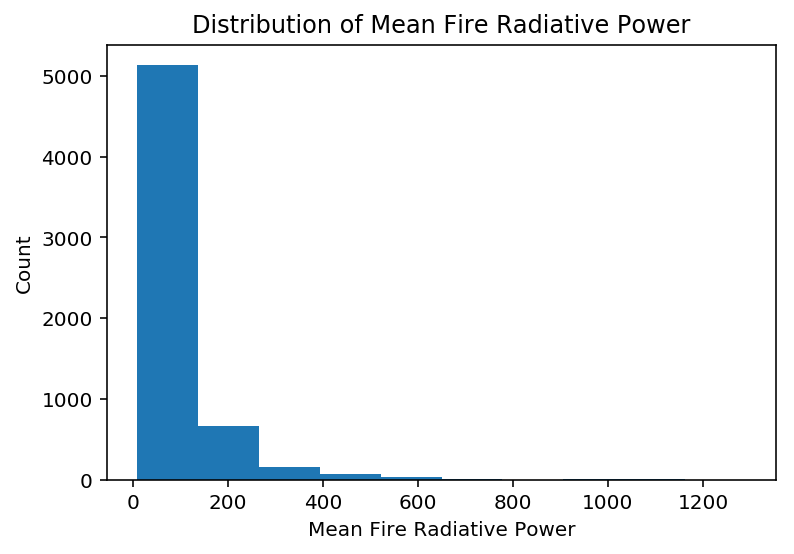

In [38]:
_ = plt.title("Distribution of Mean Fire Radiative Power")
_ = plt.xlabel("Mean Fire Radiative Power")
_ = plt.ylabel("Count")
_ = plt.hist(grouped_df['frp_mean'].values)

We can tell that the overwhelming amount of our data points come from fires with low `frp` values, but there is clearly some data that is not easily visible on this plot. Perhaps if we log scale the y-axis it will be more informative.

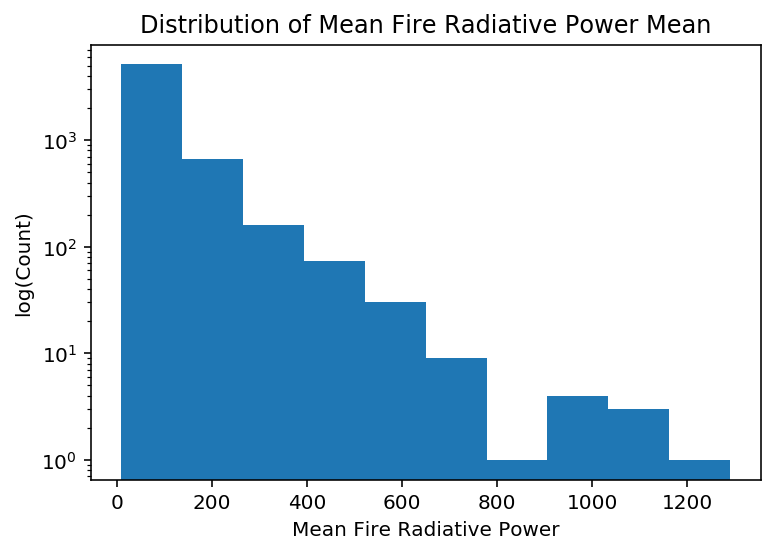

In [39]:
_ = plt.title("Distribution of Mean Fire Radiative Power Mean")
_ = plt.xlabel("Mean Fire Radiative Power")
_ = plt.ylabel("log(Count)")
_ = plt.hist(grouped_df['frp_mean'].values, log=True)

This log-scaled plot allows us to see the distribution of fires with low `frp` values more easily.

Looking at the distribution of the summed `frp` values for each group shows a similar trend:

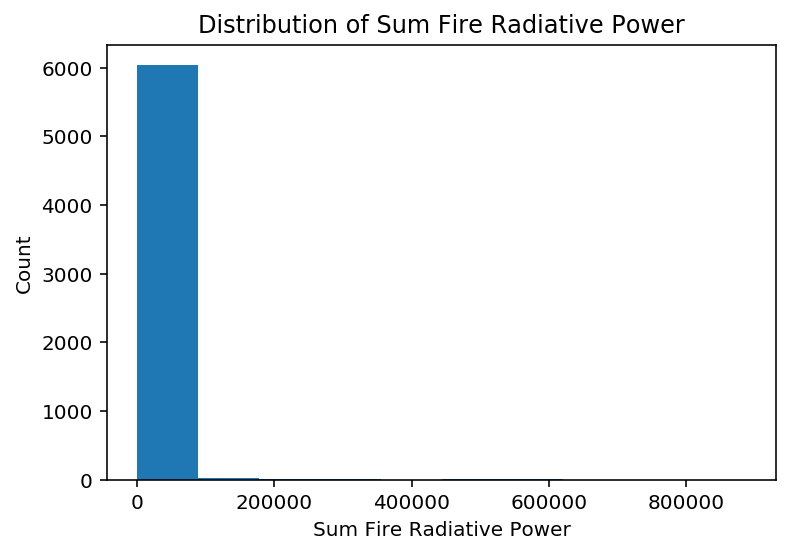

In [40]:
_ = plt.title("Distribution of Sum Fire Radiative Power")
_ = plt.xlabel("Sum Fire Radiative Power")
_ = plt.ylabel("Count")
_ = plt.hist(grouped_df['frp_sum'].values)

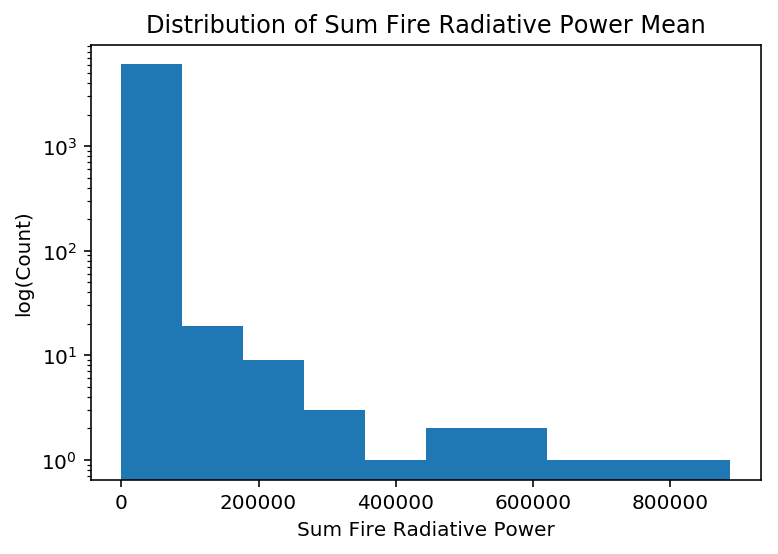

In [41]:
_ = plt.title("Distribution of Sum Fire Radiative Power Mean")
_ = plt.xlabel("Sum Fire Radiative Power")
_ = plt.ylabel("log(Count)")
_ = plt.hist(grouped_df['frp_sum'].values, log=True)

We can create these same histograms for the `vpd`, `temp`, and `humidity` variables:

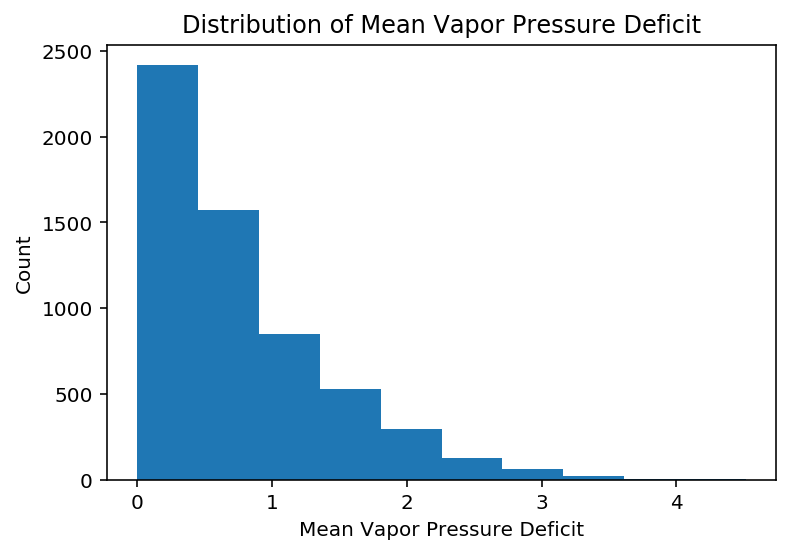

In [79]:
_ = plt.title("Distribution of Mean Vapor Pressure Deficit")
_ = plt.xlabel("Mean Vapor Pressure Deficit")
_ = plt.ylabel("Count")
_ = plt.hist(grouped_df['vpd_mean'].values)

This plot tells us that most of our `vpd` values are between 0 and 1, and the distribution is right-skewed.

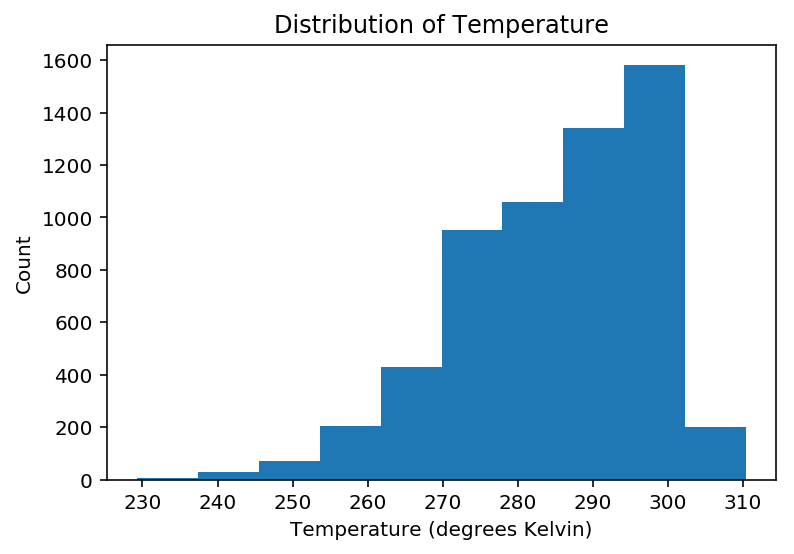

In [43]:
_ = plt.title("Distribution of Temperature")
_ = plt.xlabel("Temperature (degrees Kelvin)")
_ = plt.ylabel("Count")
_ = plt.hist(grouped_df['temp_mean'].values)

This plot shows that most of our temperature values are between 280 and 300, with a drop off after 300 and a left skew.

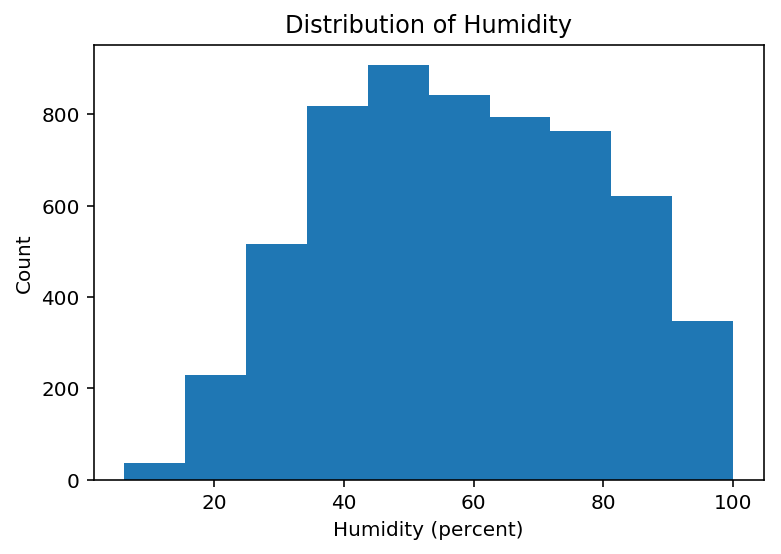

In [44]:
_ = plt.title("Distribution of Humidity")
_ = plt.xlabel("Humidity (percent)")
_ = plt.ylabel("Count")
_ = plt.hist(grouped_df['humidity_mean'].values)

This distribution of humidity values is centered near 50 percent, and fairly symmetric.

Next, we can look at the distribution over time using the `year` variable. To create this histogram we will want to bin by year rather than allowing matplotlib to choose the bins automatically, so we can use pandas `groupby` to get the counts per year explicitly:

In [45]:
year_df = grouped_df.groupby(['year_start']).size().reset_index(name='count')
year_df

year_start  count
0      2010.0    819
1      2011.0    852
2      2012.0    844
3      2013.0    878
4      2014.0    935
5      2015.0    957
6      2016.0    785

Note that now that we have the explicit counts we can use the matplotlib `bar` rather than `hist`.

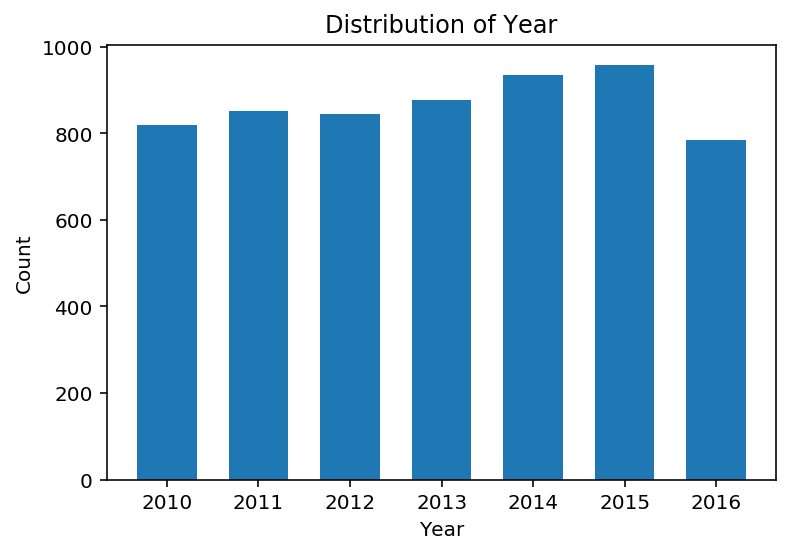

In [46]:
_ = plt.title("Distribution of Year")
_ = plt.xlabel("Year")
_ = plt.ylabel("Count")
_ = plt.bar(year_df['year_start'].values, year_df['count'].values, 0.65)

Interestingly, we see only minor differences in the number of fires per year, with a slight drop in 2016.

Next, we can look at the distribution over the year using the `dayofyear` variable.

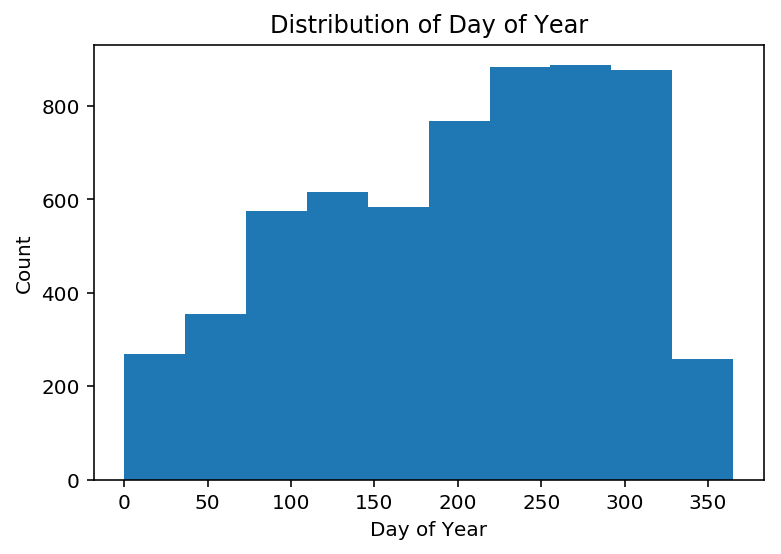

In [47]:
_ = plt.title("Distribution of Day of Year")
_ = plt.xlabel("Day of Year")
_ = plt.ylabel("Count")
_ = plt.hist(grouped_df['dayofyear_start'].values)

It looks like the majority of fires occur in the late summer or fall.

Maybe the distribution will be more clear if we are able to view this data by month rather than day.

Python's `datetime` can be used to format our month numbers into month names by creating a date object with our month number and then specifying an output date string format that only consists of the month name.

In [74]:
def month_num_to_name(month_num):
    date = datetime.date(2018, int(month_num), 1)
    return date.strftime('%B')

We will obtain counts of fires per month using pandas `groupby`.

In [49]:
month_df = grouped_df.groupby(['month_start']).size().reset_index(name='count')
month_df['month_start'] = month_df['month_start'].apply(month_num_to_name)

Once again we can create a plot using `bar` and the explicit count values.

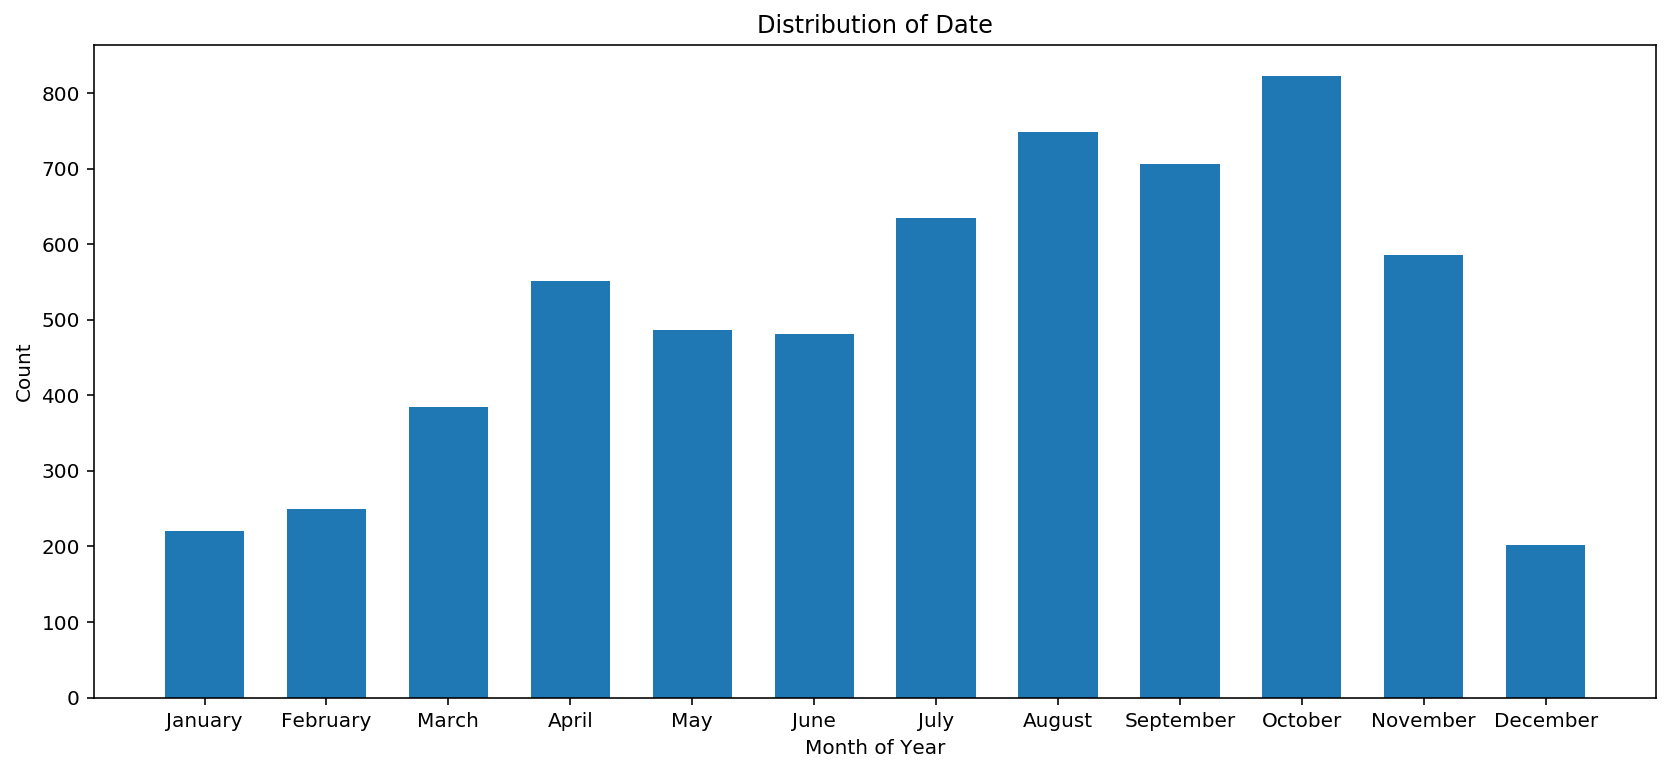

In [50]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Distribution of Date")
_ = plt.xlabel("Month of Year")
_ = plt.ylabel("Count")
bar_width = 0.65
_ = plt.bar(month_df['month_start'].values, month_df['count'].values, bar_width)

This plot confirms what we saw above, and specifically that the months of August, September, and October see the most fires.

Finally we can look at the entire span of time from 2010 to 2016 and count the fires observed each month.

In [51]:
year_month_df = grouped_df.groupby(['year_start', 'month_start']).size().reset_index(name='count')
year_month_df['year-month'] = year_month_df.apply(lambda row: ("%s %i" % (month_num_to_name(row['month_start']), int(row['year_start']))), axis='columns')
year_month_df.head()

year_start  month_start  count     year-month
0      2010.0          1.0     11   January 2010
1      2010.0          2.0     21  February 2010
2      2010.0          3.0     54     March 2010
3      2010.0          4.0     57     April 2010
4      2010.0          5.0     50       May 2010

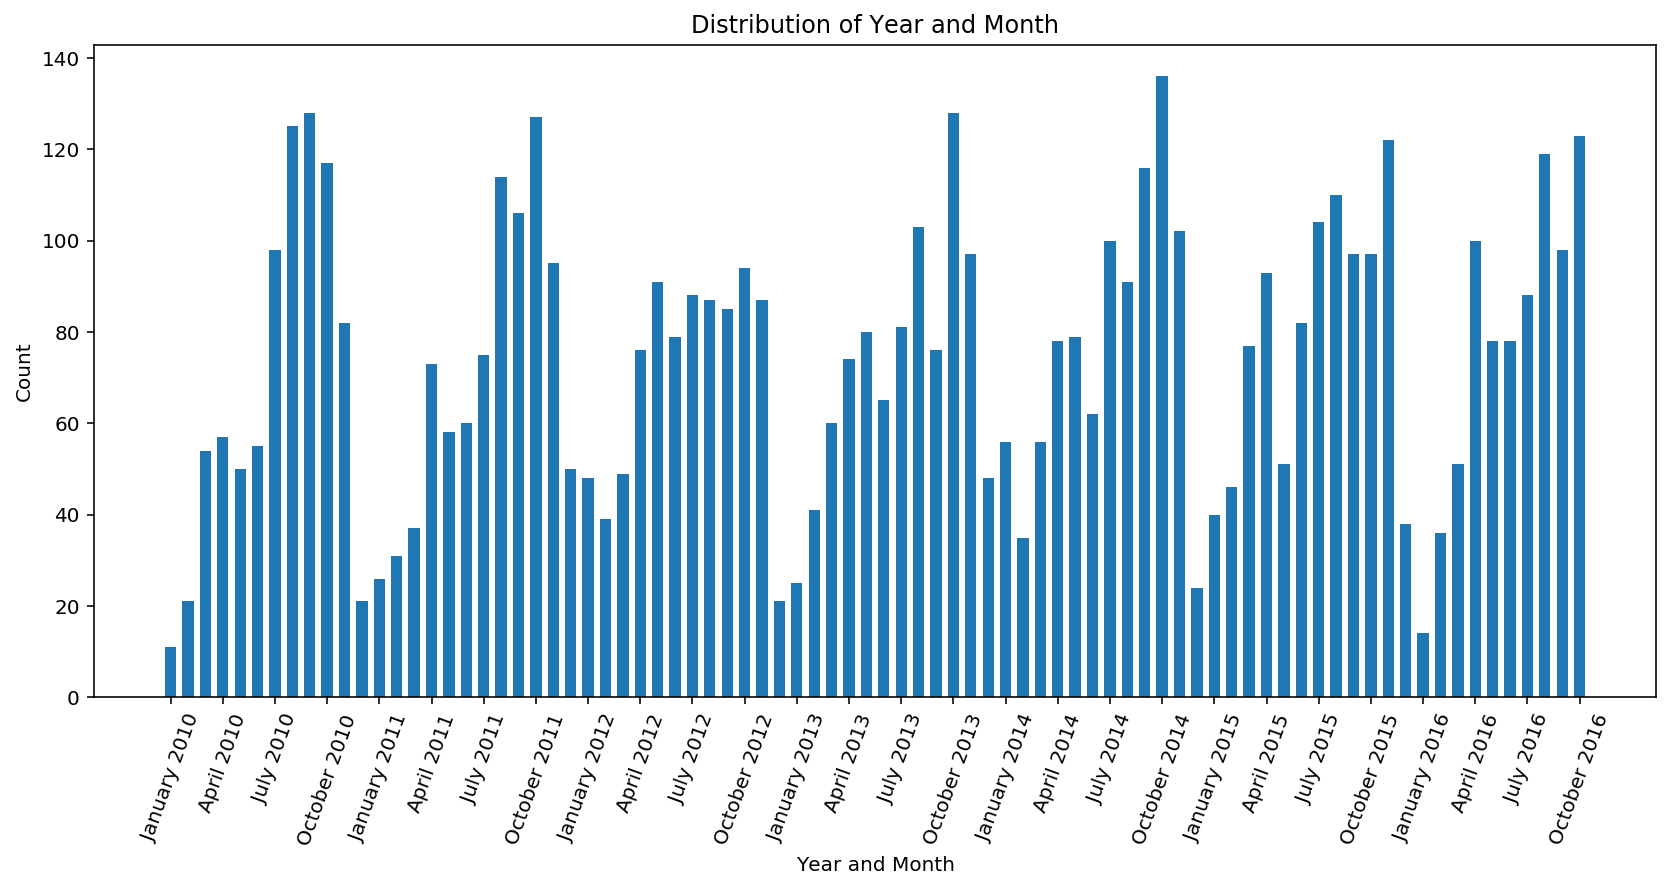

In [52]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Distribution of Year and Month")
_ = plt.xlabel("Year and Month")
_ = plt.ylabel("Count")
_ = plt.bar(year_month_df['year-month'].values, year_month_df['count'].values, 0.65)
_ = plt.xticks(year_month_df['year-month'].values[::3], rotation=70)

It looks like we see a similar pattern each year. 2012 deviates from this pattern slightly, with less of an increase in fires from the summer to the fall.

### 3.2 Multivariate Analysis

Because this wildfire data also contains location data, we can view it on a map as well. We will begin our multivariate analysis by looking at the location data in relationship to other variables.

To do so, we will load python packages to assist with geographical data visualization
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/): geographical visualization toolkit for matplotlib

In [5]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
imagery = Stamen(style='terrain-background')

To determine the extent (ranges) of our maps, we can determine the range of the latitude and longitude variables in the wildfire dataset.

In [9]:
min_lon = df['lon'].min()
max_lon = df['lon'].max()
min_lon -= (max_lon - min_lon) * 0.2
min_lat = df['lat'].min()
max_lat = df['lat'].max()

For our visualization, we will plot fires from different years using different colors. To do so, matplotlib's colormap module can be used to map each year to a color of the rainbow. 

We will make this conventient for ourselves later by creating a function that will generalize this mapping to any sorted array.

In [10]:
def get_cmap_dict(vals, cmap_name='rainbow', numeric=True):
    cmap = cm.get_cmap(cmap_name)
    if numeric:
        # assume vals already sorted
        min_val = vals[0]
        max_val = vals[-1]
        return dict(zip(vals, [cmap((val - min_val) / (max_val - min_val)) for val in vals]))
    else:
        len_vals = len(vals)
        return dict(zip(vals, [cmap(val / len_vals) for val in range(len_vals)]))

In [11]:
years = list(df['year'].unique())
year_to_color_map = get_cmap_dict(years)

Because the plot could become cluttered and difficult to interpret, we will first restrict the fires to those with the top strength (`frp`) for each year.

In [12]:
n_per_year = 30
df_top_frp = df.sort_values(['frp'], ascending=False)
df_top_frp_year_groupby = df_top_frp.groupby(['year'])

Next we will need to determine the minimum and maximum strength values, which will help us to make a legend.

In [13]:
min_frp = df_top_frp_year_groupby.min()['frp'].min()
max_frp = df_top_frp_year_groupby.max()['frp'].max()
frp_intervals = np.linspace(max_frp, min_frp, 4, endpoint=False)

Now we will create the plot.

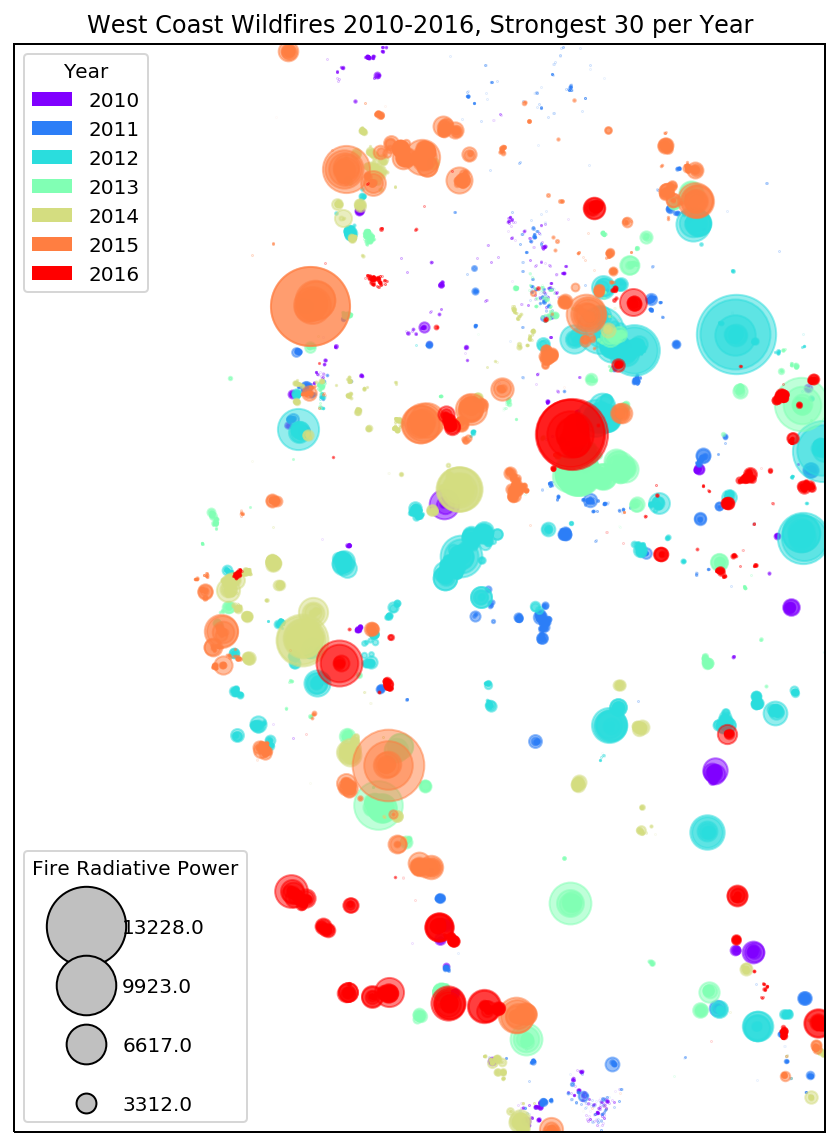

In [57]:
grouped_df_top_frp = grouped_df.sort_values(['frp_sum'], ascending=False)
grouped_df_top_frp_year_groupby = grouped_df_top_frp.groupby(['year_start'])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
_ = ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())
#_ = ax.add_image(imagery, 8)
frp_scaling_factor = 0.003
for year, df_top_frp_year in grouped_df_top_frp_year_groupby:
    for group_index, group_row in df_top_frp_year.head(n_per_year).iterrows():
        for fire_index, fire_row in df.loc[df['fire_group_index'] == group_row['fire_group_index']].sort_values(['frp'], ascending=False).head(100).iterrows():
            _ = plt.plot(
                fire_row['lon'], 
                fire_row['lat'], 
                marker='o', 
                color=year_to_color_map[fire_row['year']], 
                markersize=(frp_scaling_factor*fire_row['frp']), 
                alpha=0.5, 
                transform=ccrs.Geodetic()
            )
_ = ax.set_title("West Coast Wildfires 2010-2016, Strongest %i per Year" % n_per_year)

year_legend_elements = [Patch(facecolor=year_color, label=year) for year, year_color in year_to_color_map.items()]
year_legend = ax.legend(handles=year_legend_elements, loc='upper left', title='Year')
_ = plt.gca().add_artist(year_legend)

frp_legend_elements = [Line2D([0], [0], marker='o', color=(0,0,0,0), label=np.floor(frp_val), markerfacecolor='#C0C0C0', markersize=frp_val*frp_scaling_factor) for frp_val in frp_intervals]
_ = ax.legend(handles=frp_legend_elements, loc='lower left', labelspacing=2, columnspacing=2, title='Fire Radiative Power')

And the same plot as above, uncommenting the add imagery line to show the terrain:

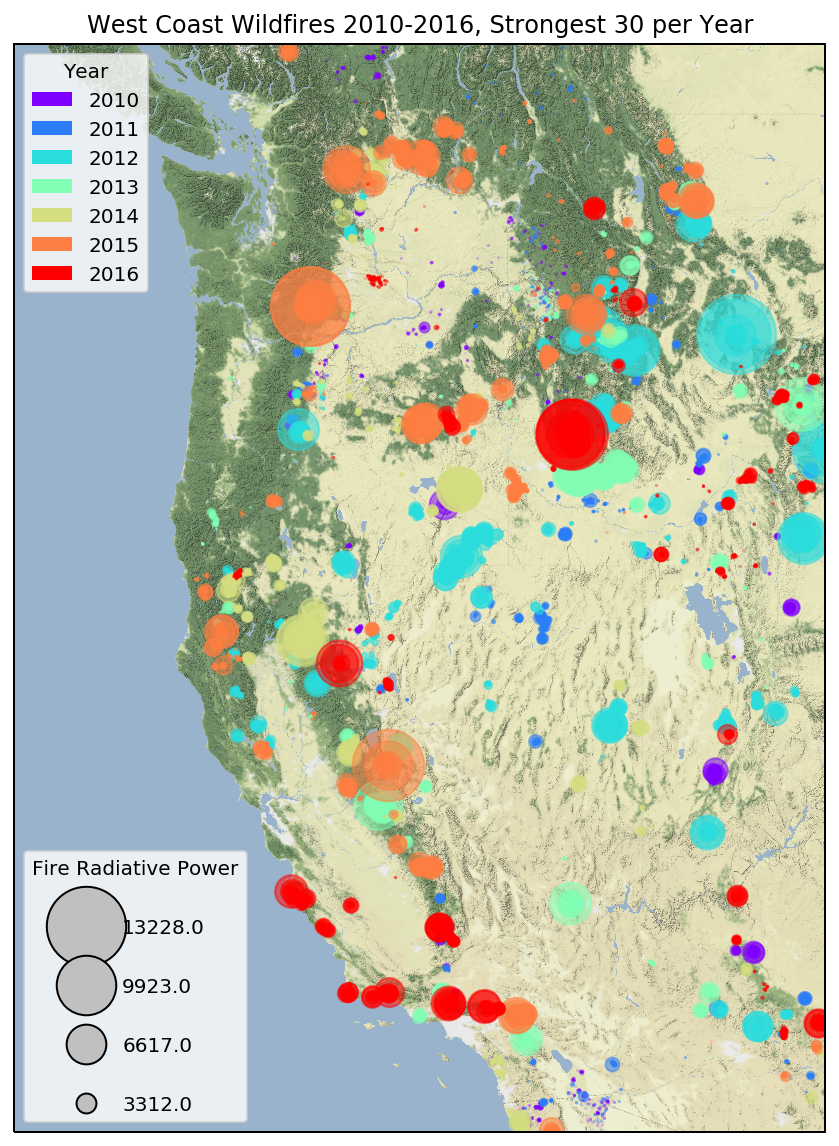

In [58]:
grouped_df_top_frp = grouped_df.sort_values(['frp_sum'], ascending=False)
grouped_df_top_frp_year_groupby = grouped_df_top_frp.groupby(['year_start'])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
_ = ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())
_ = ax.add_image(imagery, 8)
frp_scaling_factor = 0.003
for year, df_top_frp_year in grouped_df_top_frp_year_groupby:
    for group_index, group_row in df_top_frp_year.head(n_per_year).iterrows():
        for fire_index, fire_row in df.loc[df['fire_group_index'] == group_row['fire_group_index']].sort_values(['frp'], ascending=False).head(100).iterrows():
            _ = plt.plot(
                fire_row['lon'], 
                fire_row['lat'], 
                marker='o', 
                color=year_to_color_map[fire_row['year']], 
                markersize=(frp_scaling_factor*fire_row['frp']), 
                alpha=0.5, 
                transform=ccrs.Geodetic()
            )
_ = ax.set_title("West Coast Wildfires 2010-2016, Strongest %i per Year" % n_per_year)

year_legend_elements = [Patch(facecolor=year_color, label=year) for year, year_color in year_to_color_map.items()]
year_legend = ax.legend(handles=year_legend_elements, loc='upper left', title='Year')
_ = plt.gca().add_artist(year_legend)

frp_legend_elements = [Line2D([0], [0], marker='o', color=(0,0,0,0), label=np.floor(frp_val), markerfacecolor='#C0C0C0', markersize=frp_val*frp_scaling_factor) for frp_val in frp_intervals]
_ = ax.legend(handles=frp_legend_elements, loc='lower left', labelspacing=2, columnspacing=2, title='Fire Radiative Power')

Next we can perform multivariate analysis of the rest of our data and ask ourselves whether we see relationships between any of our variables.

In the following plot we will look at temperature over time, with different colors for each year.

Next, we can incorporate year by coloring each point based on year.

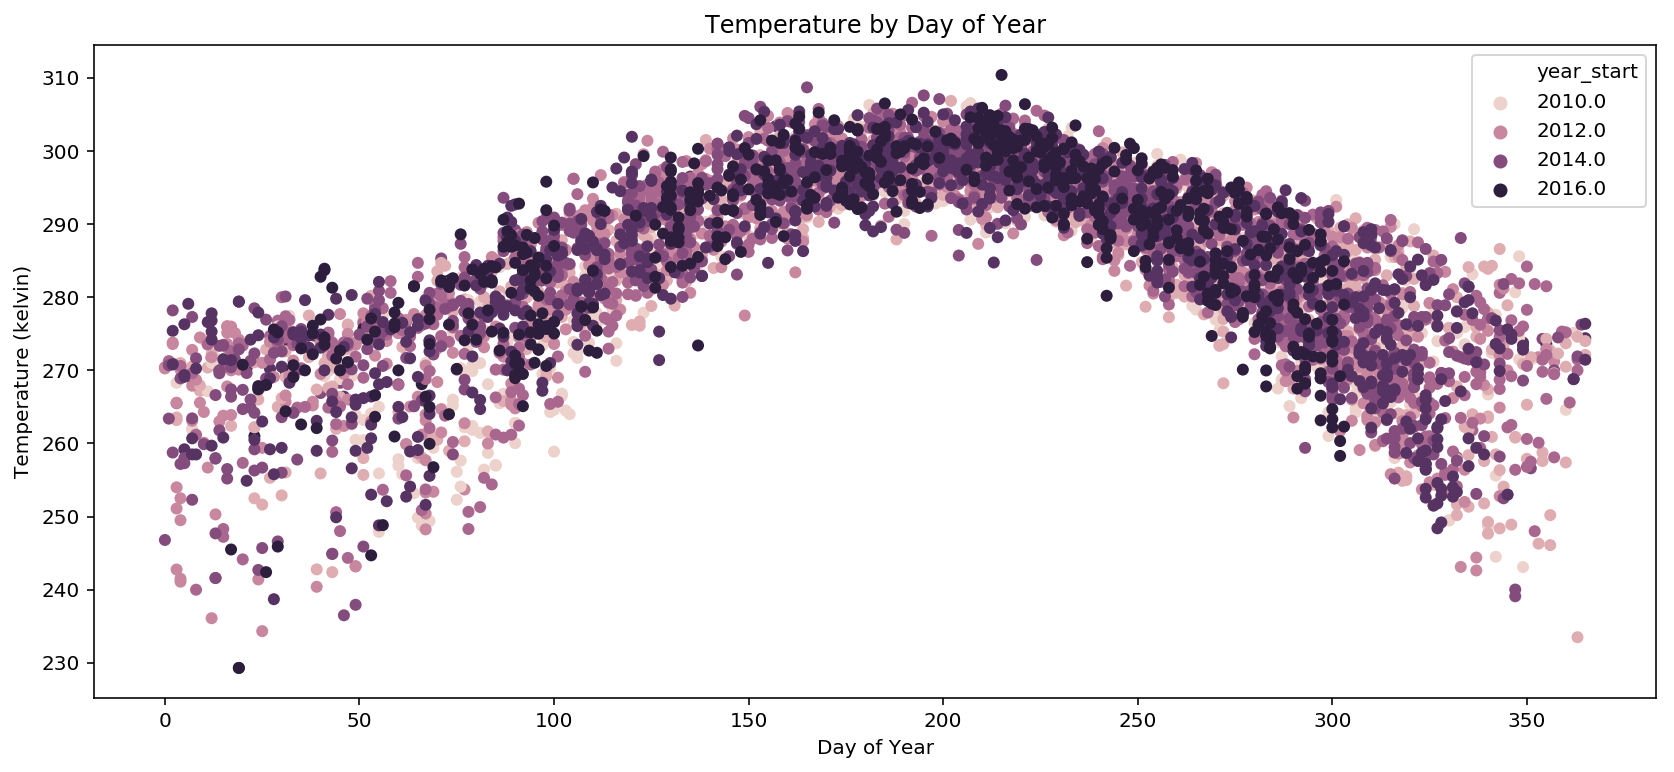

In [61]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Temperature by Day of Year")
_ = sns.scatterplot(x="dayofyear_start", y="temp_mean", hue="year_start", data=grouped_df, linewidth=0)
_ = plt.xlabel("Day of Year")
_ = plt.ylabel("Temperature (kelvin)")

In [75]:
year_month_mean_df = grouped_df.groupby(['year_start', 'month_start']).mean().reset_index()

In [76]:
month_tick_formatter = matplotlib.ticker.FuncFormatter(lambda x, p: month_num_to_name(int(x)) if x >= 1 and x <= 12 else "")

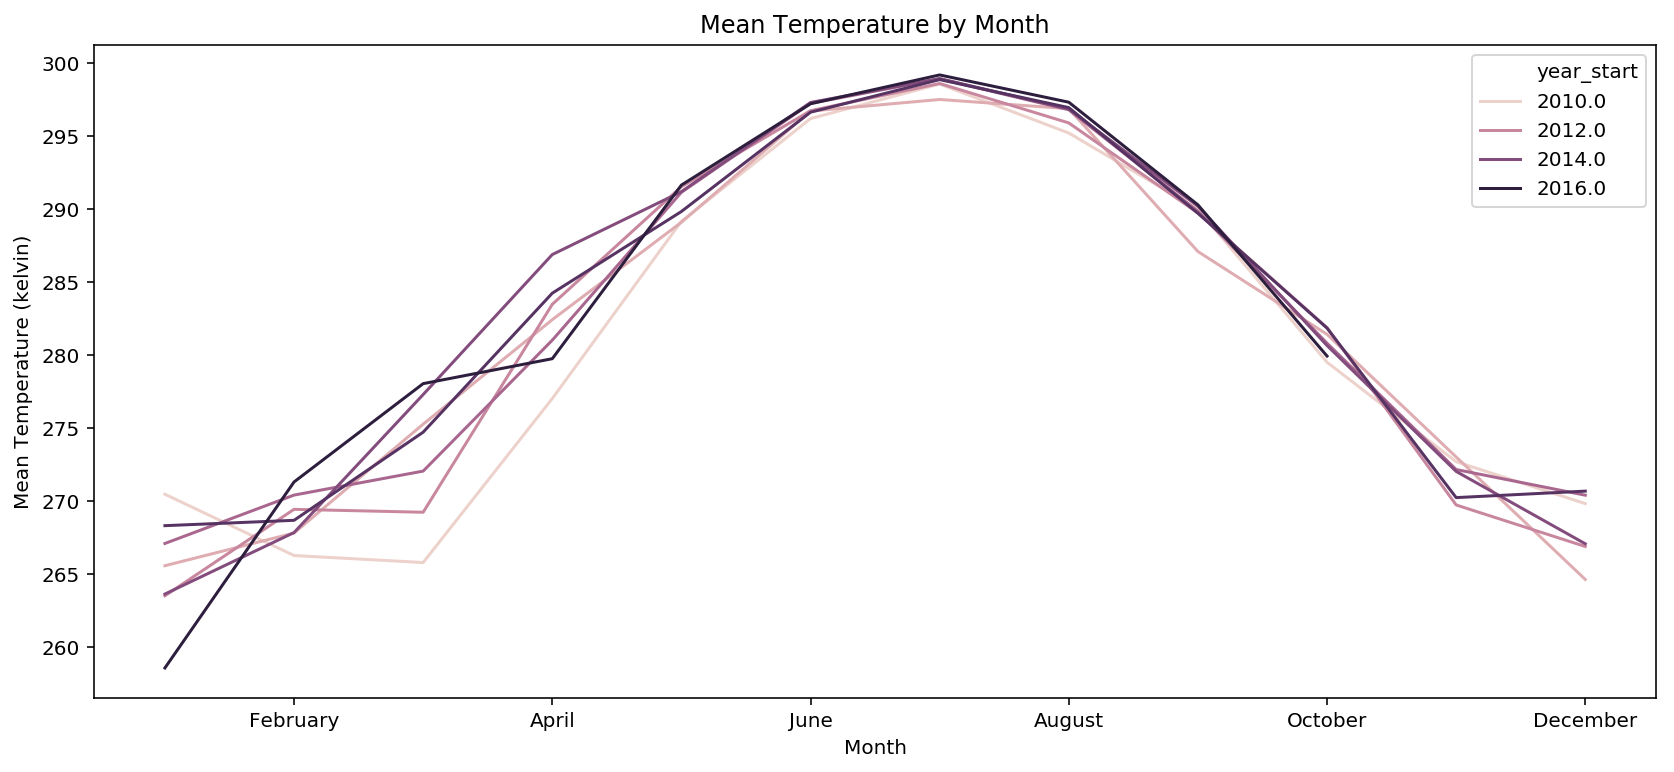

In [77]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Mean Temperature by Month")
ax = sns.lineplot(x="month_start", y="temp_mean", hue="year_start", data=year_month_mean_df)
_ = plt.xlabel("Month")
_ = plt.ylabel("Mean Temperature (kelvin)")
_ = ax.xaxis.set_major_formatter(month_tick_formatter)

Because we have many more variable pairs to evaluate, we can start to look at correlations.

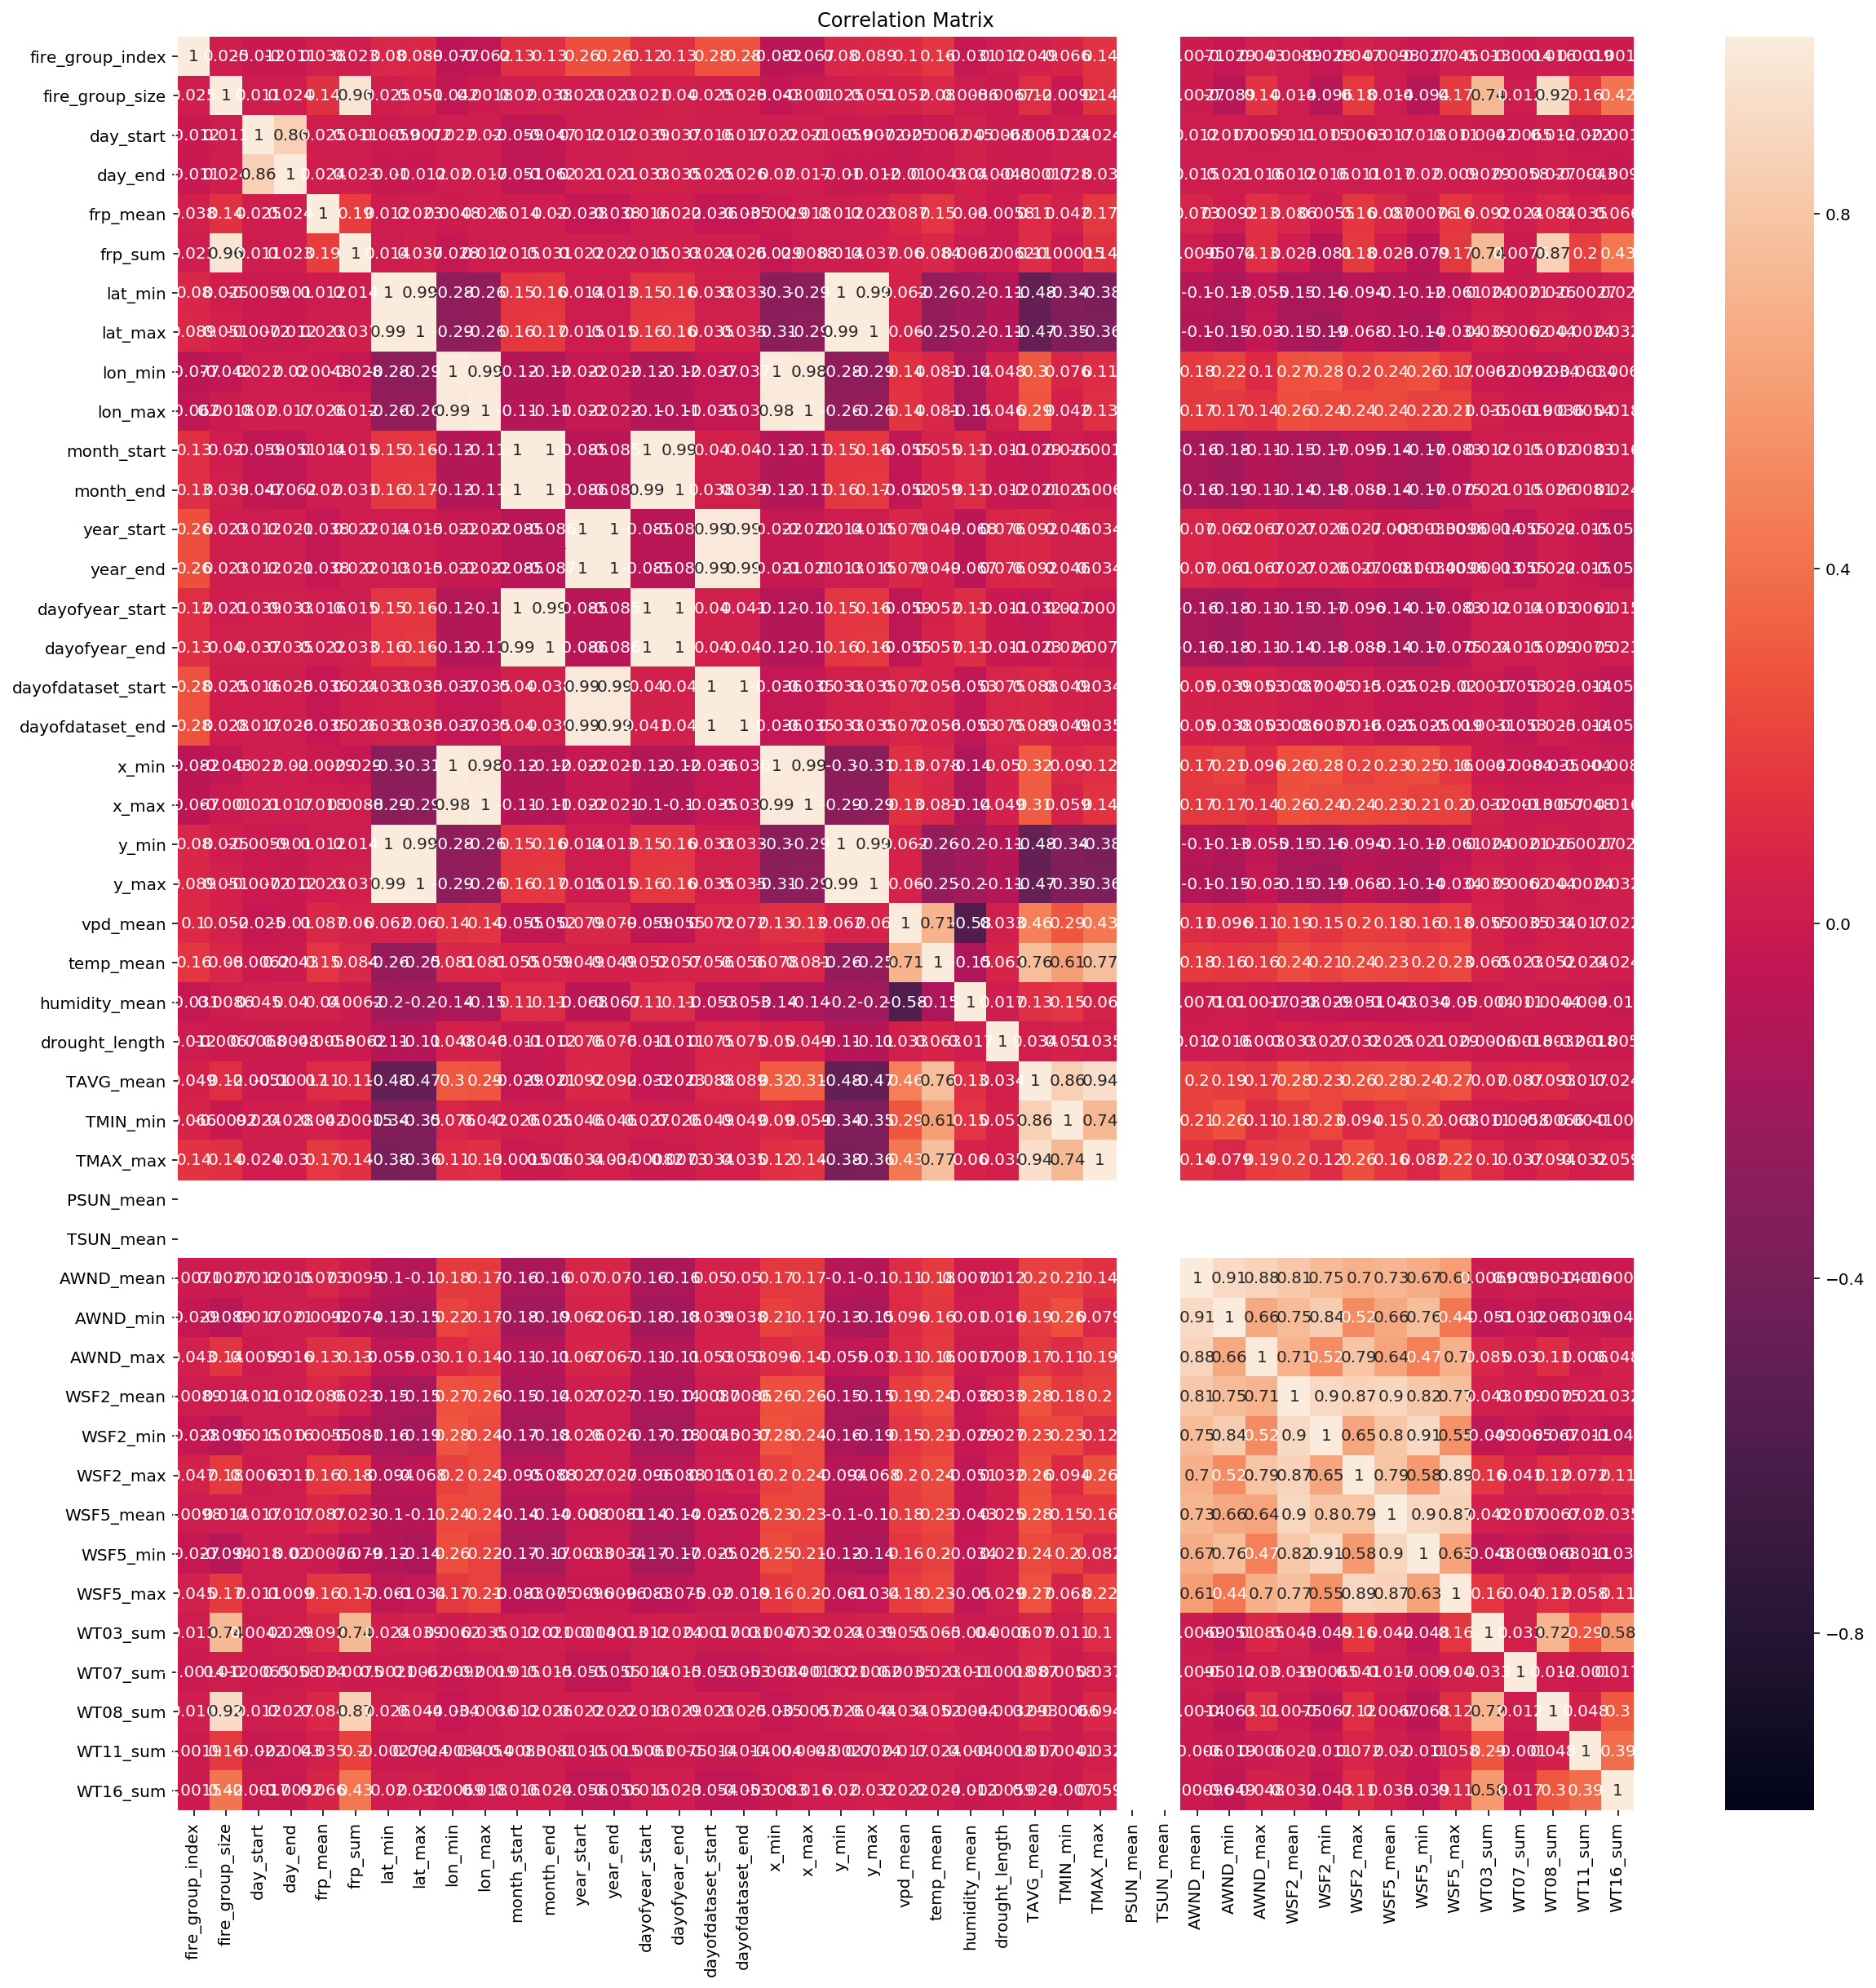

In [91]:
corr_df = grouped_df.corr()
_ = plt.figure(figsize=(20,20))
_ = sns.heatmap(corr_df, annot=True, vmin=-1, vmax=1)
_ = plt.title("Correlation Matrix")

From this matrix, we can tell that many of our variables do not have a strong linear relationship.

However, there are a few correlations to note, which we should inspect in more detail:
- `WT03_sum` (thunder) and `fire_group_size`
- `WT03_sum` (thunder) and `frp_sum`

As well as some expected correlations:
- `frp_sum` and `fire_group_size`: A larger "fire group" is comprised of more fire observations and thus more `frp` values
- `x` and `lon`: The values for `x` are just converted `lon` values
- `y` and `lat`: The values for `y` are just converted `lat` values
- The date columns: many are simply conversions of the others
- The weather columns: many are variations of the others
- `WT08_sum` (smoke) and `fire_group_size`: larger fires generate more smoke
- `WT08_sum` (smoke) and `frp_sum`: larger fires generate more smoke
- `TAVG` and `lat`: climate changes based on distance from equator
- `TAVG` and `temp`: both are measures temperature, but one comes from the fire data and the other comes from the weather data
- `vpd_mean` and `temp_mean`/`humidity_mean`: vapor pressure deficit is a function of temperature and humidity

We can also tell from this heatmap that all of our sun weather observations (`PSUN`, `TSUN`) are NaN.

Now we will look at some relationships of interest:

We can use `seaborn`'s `regplot` function to easily look at scatterplots containing a line of best fit and corresponding confidence interval:

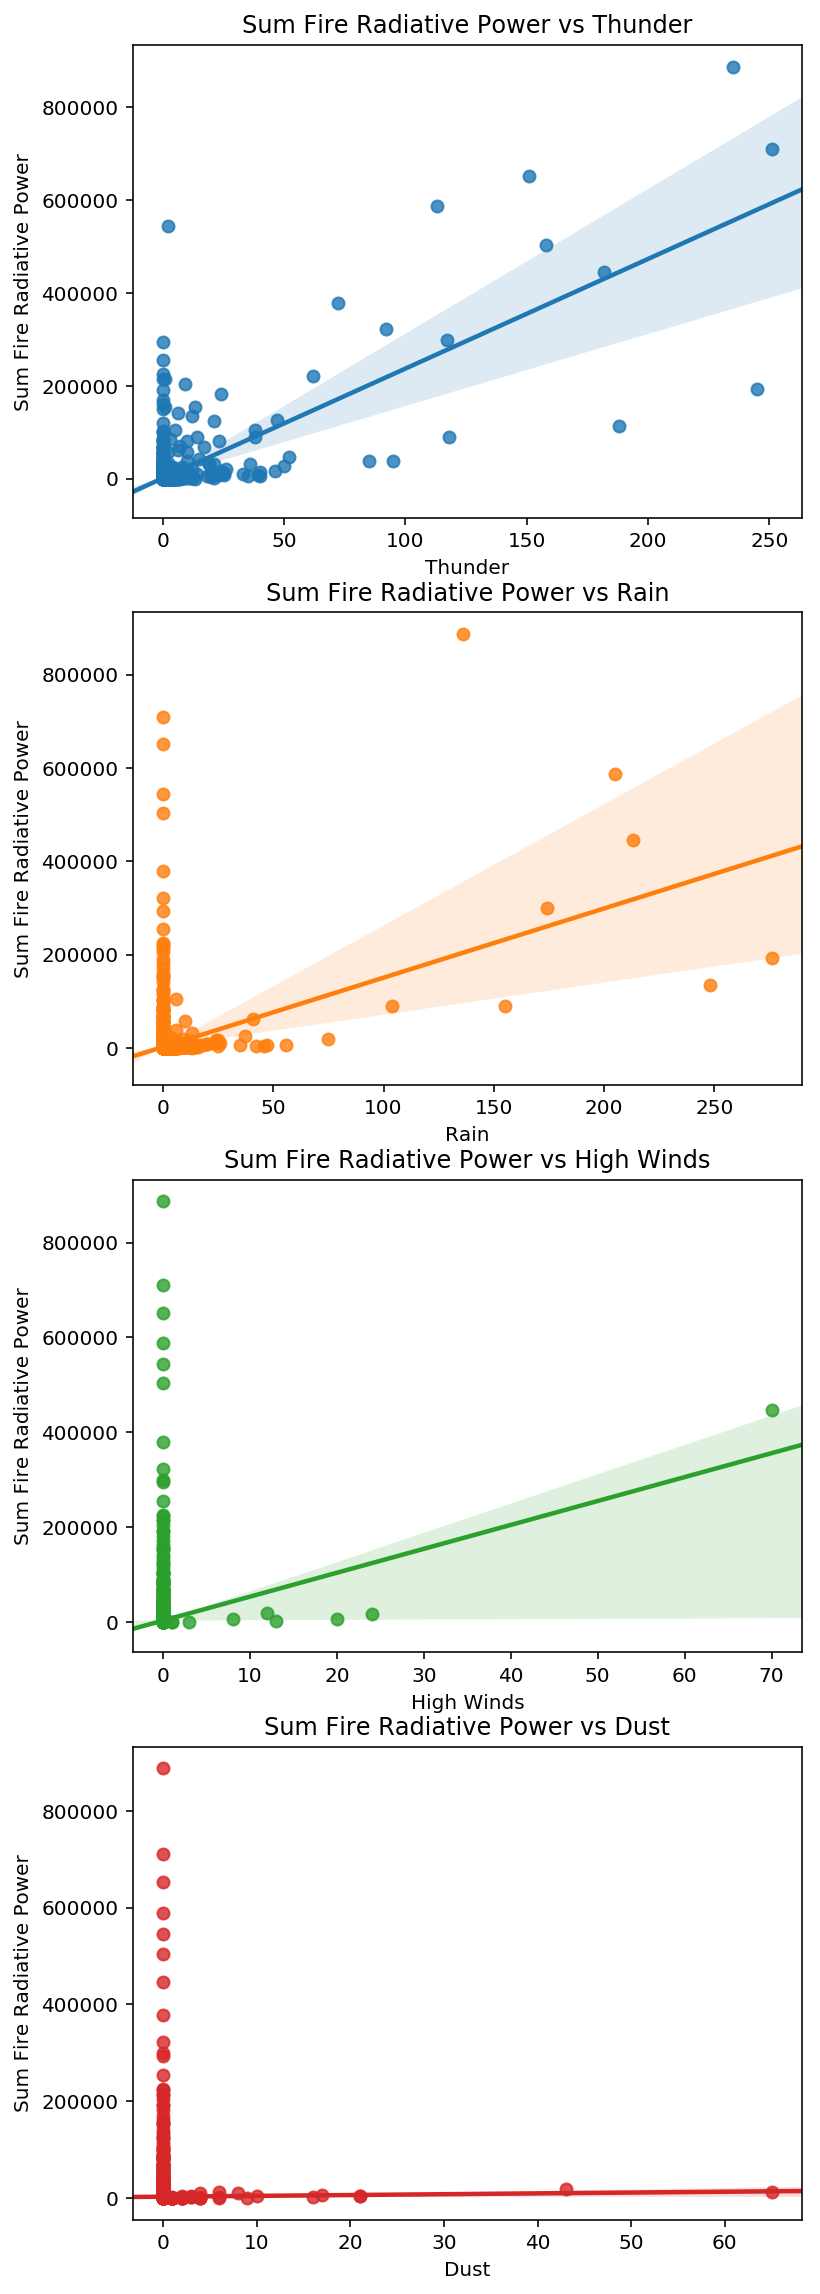

In [123]:
fig, axes = plt.subplots(4, 1, figsize=(6, 20))

_ = sns.regplot(x="WT03_sum", y="frp_sum", data=grouped_df, ax=axes[0])
_ = axes[0].set_xlabel("Thunder")
_ = axes[0].set_ylabel("Sum Fire Radiative Power")
_ = axes[0].set_title("Sum Fire Radiative Power vs Thunder")

_ = sns.regplot(x="WT16_sum", y="frp_sum", data=grouped_df, ax=axes[1])
_ = axes[1].set_xlabel("Rain")
_ = axes[1].set_ylabel("Sum Fire Radiative Power")
_ = axes[1].set_title("Sum Fire Radiative Power vs Rain")

_ = sns.regplot(x="WT11_sum", y="frp_sum", data=grouped_df, ax=axes[2])
_ = axes[2].set_xlabel("High Winds")
_ = axes[2].set_ylabel("Sum Fire Radiative Power")
_ = axes[2].set_title("Sum Fire Radiative Power vs High Winds")

_ = sns.regplot(x="WT07_sum", y="frp_sum", data=grouped_df, ax=axes[3])
_ = axes[3].set_xlabel("Dust")
_ = axes[3].set_ylabel("Sum Fire Radiative Power")
_ = axes[3].set_title("Sum Fire Radiative Power vs Dust")

This plot shows that of the fires with higher summed fire radiative power values, we see more instances of thunder. There is a slightly weaker relationship with rain and winds, and no relationship with dust. 

And as expected, a very strong relationship with smoke:

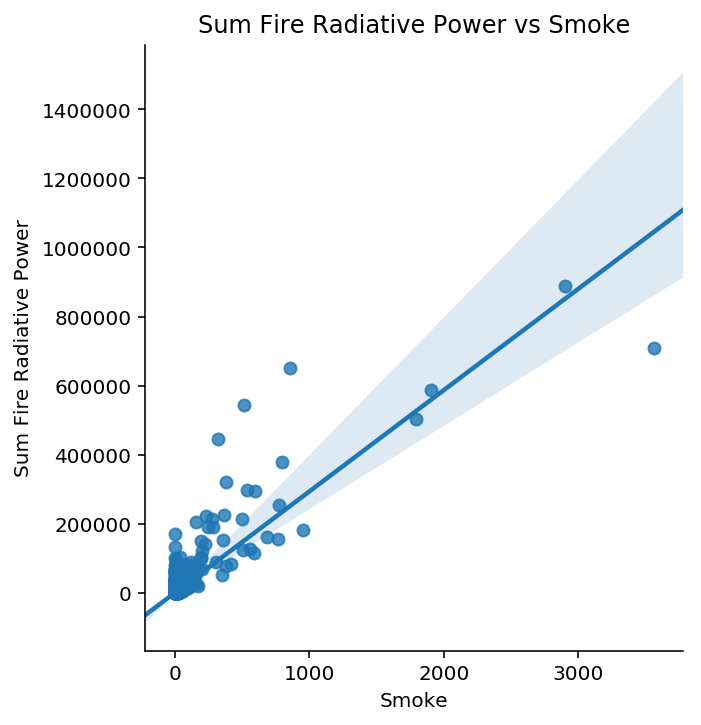

In [105]:
_ = sns.lmplot(x="WT08_sum", y="frp_sum", data=grouped_df)
_ = plt.xlabel("Smoke")
_ = plt.ylabel("Sum Fire Radiative Power")
_ = plt.title("Sum Fire Radiative Power vs Smoke")

And a closer look at some of the additional pairs of variables which do not have a clear linear relationship:

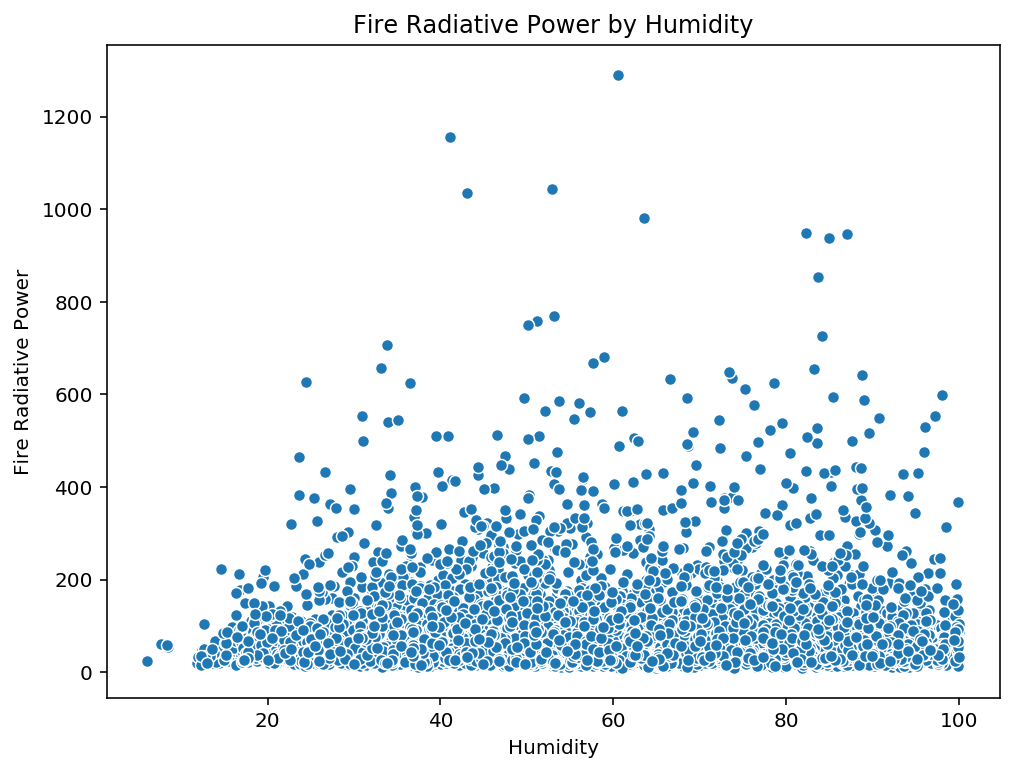

In [88]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Fire Radiative Power by Humidity")
_ = sns.scatterplot(x="humidity_mean", y="frp_mean", data=grouped_df)
_ = plt.xlabel("Humidity")
_ = plt.ylabel("Fire Radiative Power")

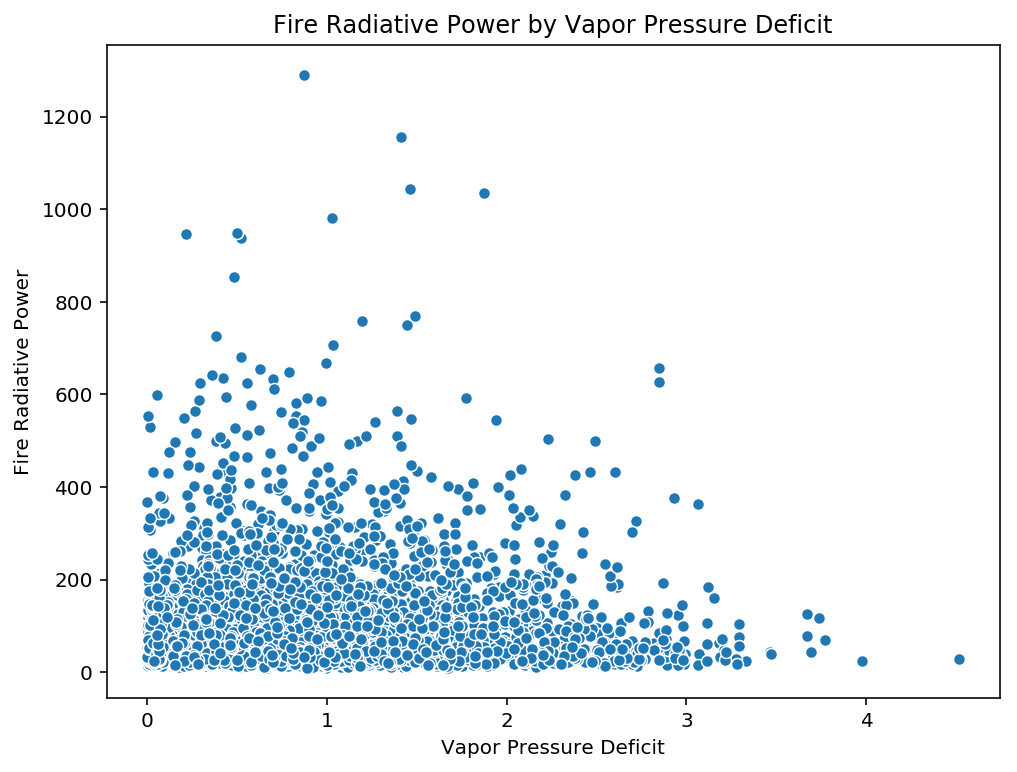

In [90]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Fire Radiative Power by Vapor Pressure Deficit")
_ = sns.scatterplot(x="vpd_mean", y="frp_mean", data=grouped_df)
_ = plt.xlabel("Vapor Pressure Deficit")
_ = plt.ylabel("Fire Radiative Power")

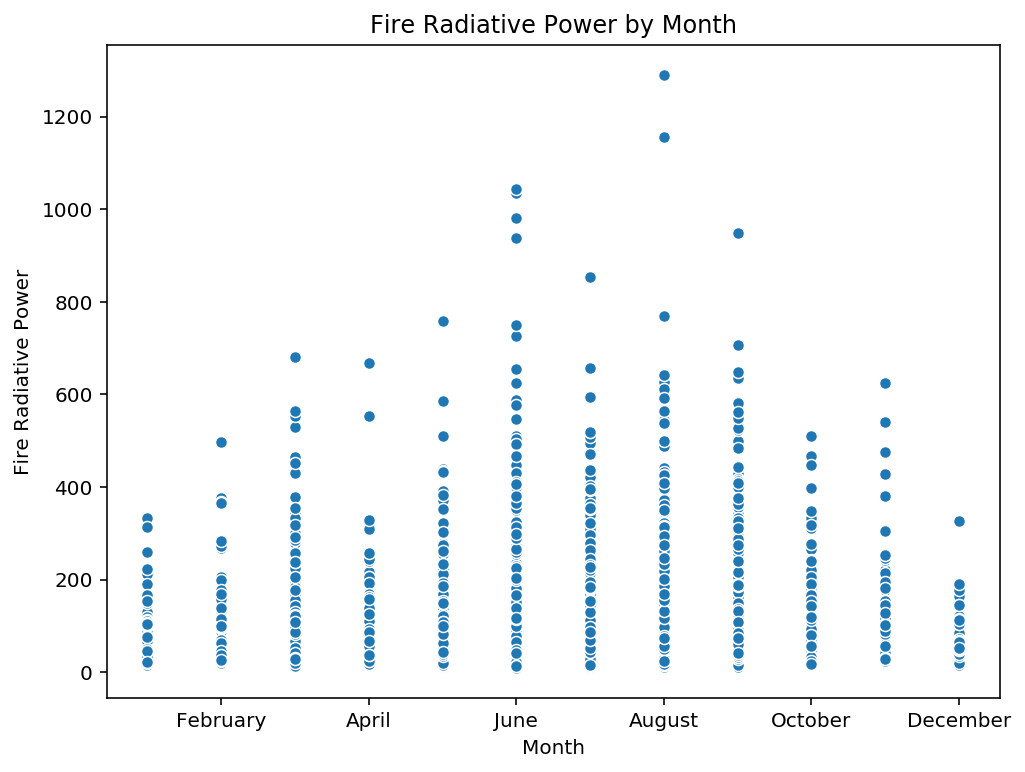

In [124]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Fire Radiative Power by Month")
ax = sns.scatterplot(x="month_start", y="frp_mean", data=grouped_df)
_ = plt.xlabel("Month")
_ = plt.ylabel("Fire Radiative Power")
_ = ax.xaxis.set_major_formatter(month_tick_formatter)

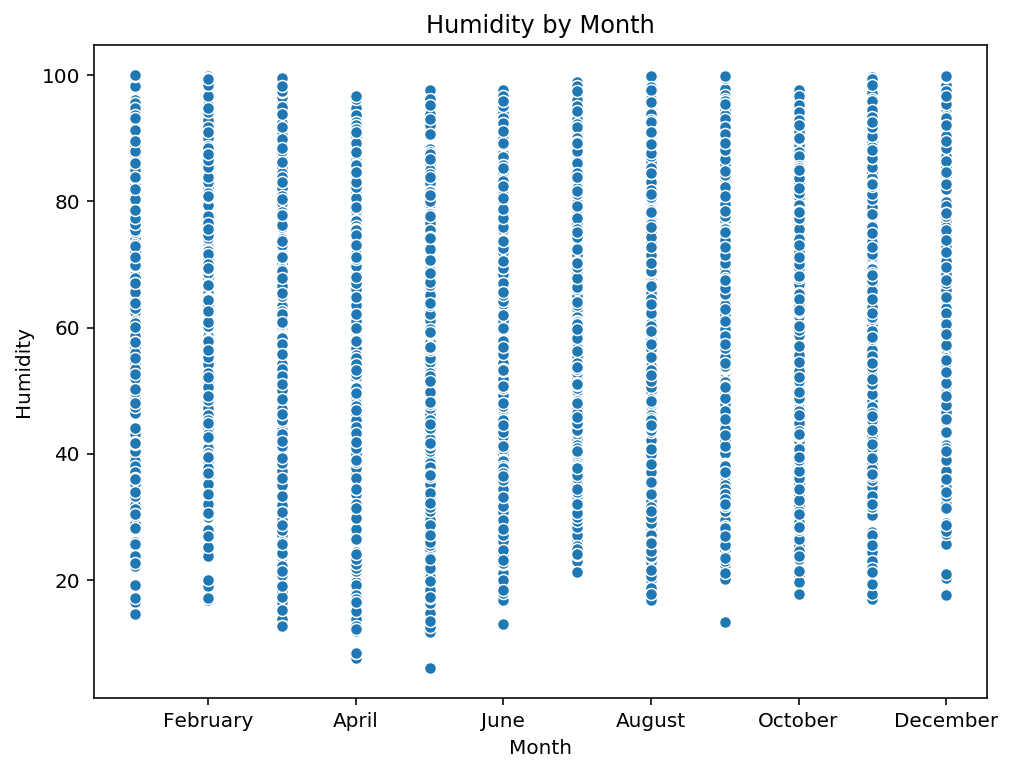

In [125]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Humidity by Month")
ax = sns.scatterplot(x="month_start", y="humidity_mean", data=grouped_df)
_ = plt.xlabel("Month")
_ = plt.ylabel("Humidity")
_ = ax.xaxis.set_major_formatter(month_tick_formatter)

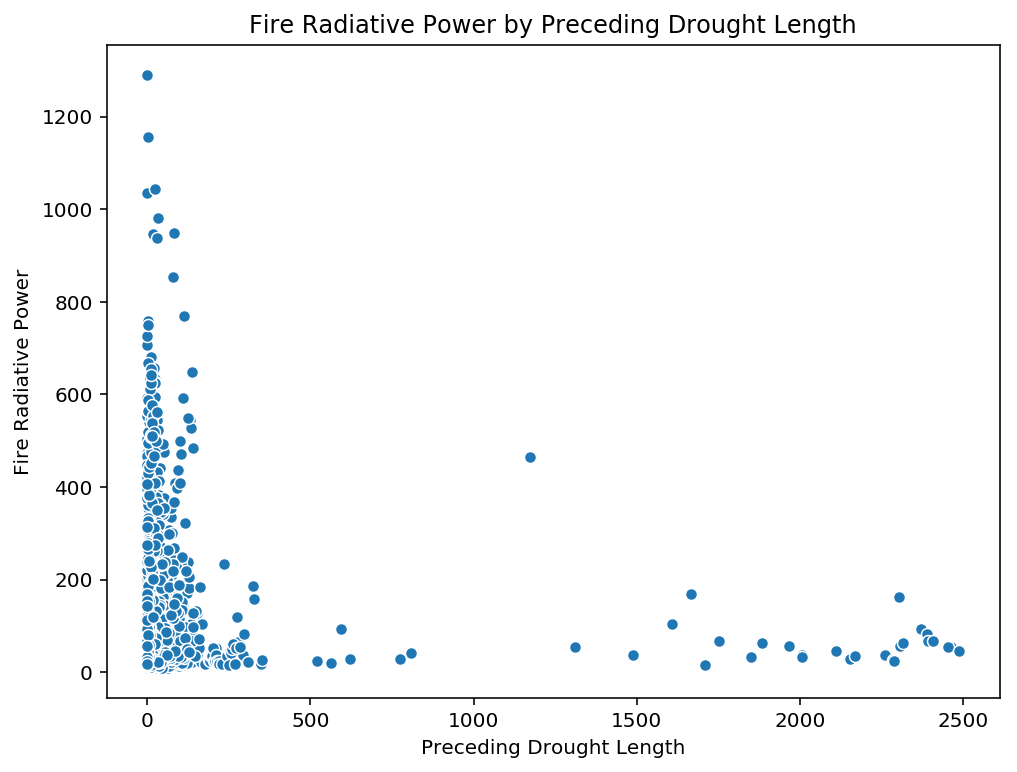

In [130]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Fire Radiative Power by Preceding Drought Length")
_ = sns.scatterplot(x="drought_length", y="frp_mean", data=grouped_df)
_ = plt.xlabel("Preceding Drought Length")
_ = plt.ylabel("Fire Radiative Power")

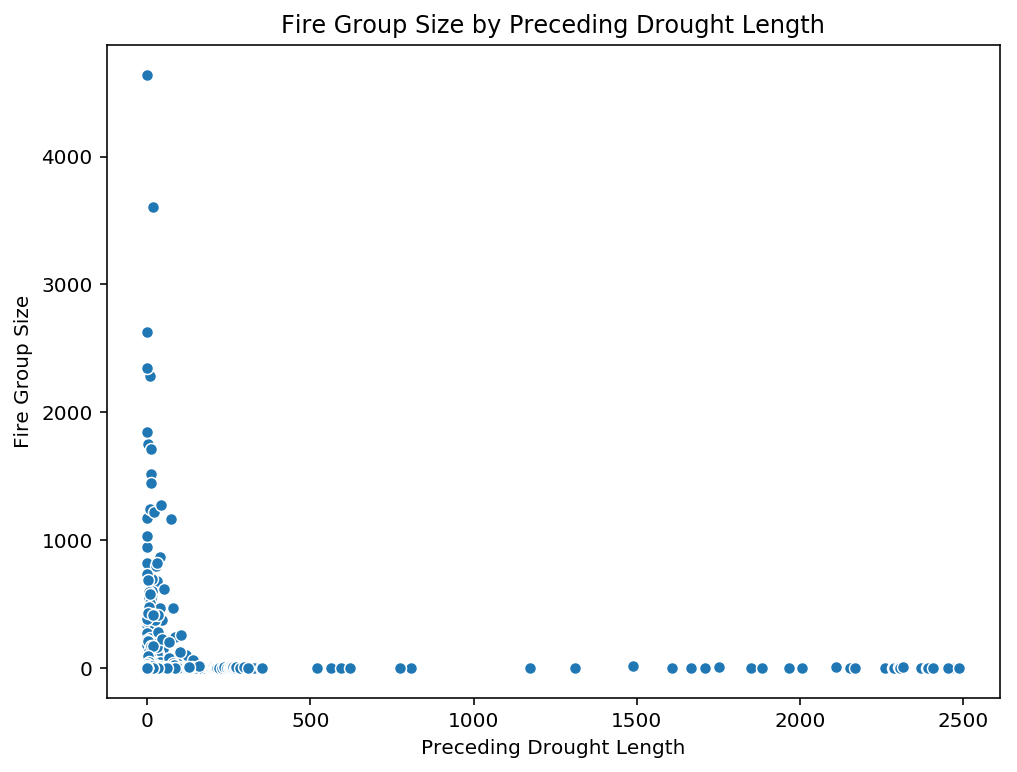

In [132]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Fire Group Size by Preceding Drought Length")
_ = sns.scatterplot(x="drought_length", y="fire_group_size", data=grouped_df)
_ = plt.xlabel("Preceding Drought Length")
_ = plt.ylabel("Fire Group Size")

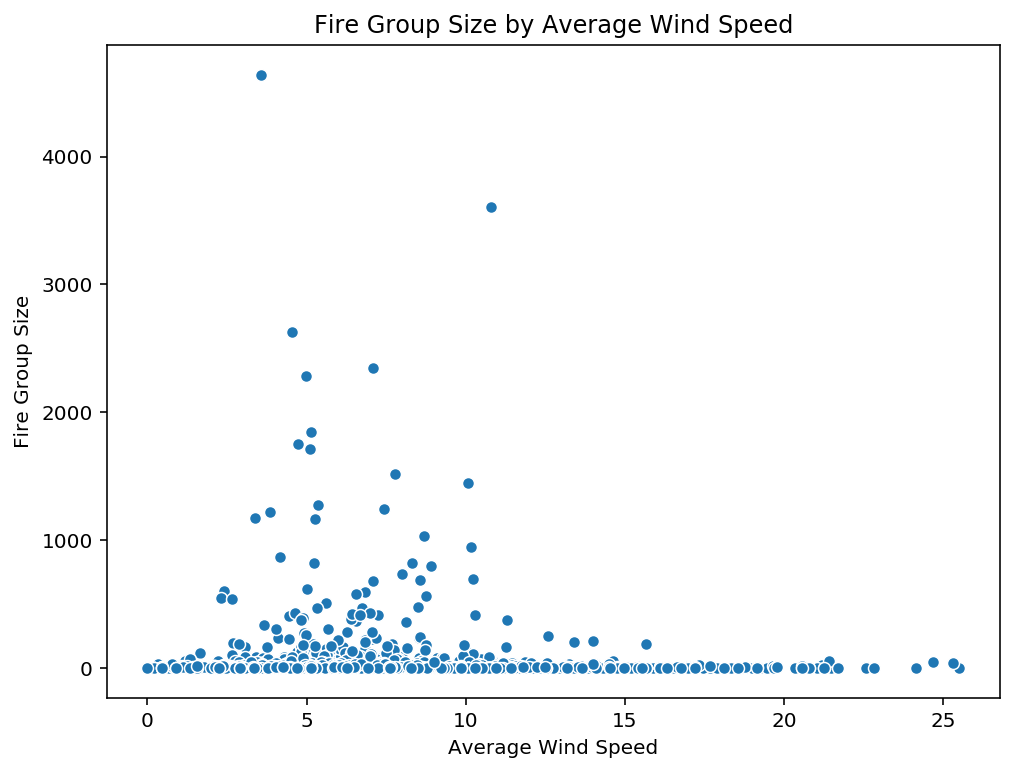

In [133]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Fire Group Size by Average Wind Speed")
_ = sns.scatterplot(x="AWND_mean", y="fire_group_size", data=grouped_df)
_ = plt.xlabel("Average Wind Speed")
_ = plt.ylabel("Fire Group Size")

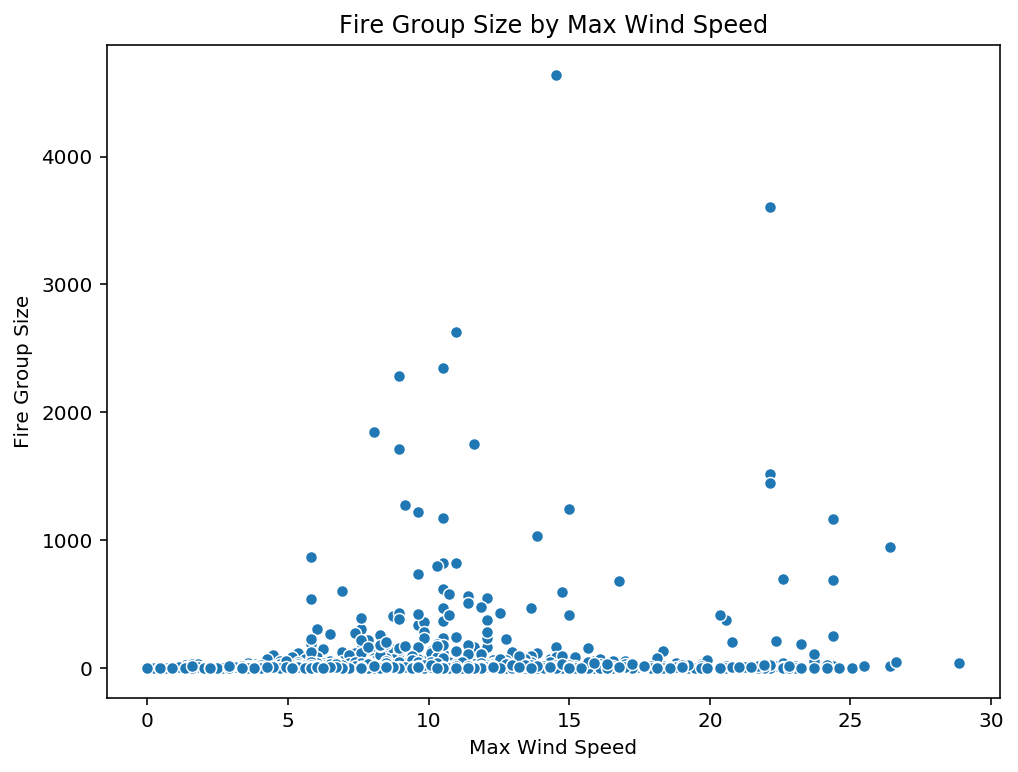

In [146]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Fire Group Size by Max Wind Speed")
_ = sns.scatterplot(x="AWND_max", y="fire_group_size", data=grouped_df)
_ = plt.xlabel("Max Wind Speed")
_ = plt.ylabel("Fire Group Size")

## 4. Hypothesis Testing

To perform hypothesis testing, we can load the [statsmodels](https://www.statsmodels.org/stable/index.html) package, which contains functions for statistical analysis including t-testing, linear regression, ANOVA, and much more.

In [131]:
import statsmodels.api as sm

### 4.1 Testing Drought and Fire Radiative Power

First we might want to test the hypothesis that a longer period of drought preceding a fire results in a higher powered fire.

To perform this test, we can set our null and alternative hypotheses. The null hypothesis will be that the coefficient of the linear model is not different from zero.
$$
\text{H}_0 : \beta_1 = 0 \\
\text{H}_a : \beta_1 \neq 0
$$

In [136]:
X = grouped_df[['drought_length']].values
X = sm.add_constant(X)
y = grouped_df['frp_mean'].values

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2034
Date:                Wed, 12 Dec 2018   Prob (F-statistic):              0.652
Time:                        23:07:23   Log-Likelihood:                -36198.
No. Observations:                6070   AIC:                         7.240e+04
Df Residuals:                    6068   BIC:                         7.241e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.4899      1.223     71.516      0.000      85.092      89.888
x1            -0.0037      0.008     -0.451      0.652      -0.020       0.012
==============================================================================
Omnibus:                     5059.718   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159799.845
Skew:                           3.869   Prob(JB):                         0.00
Kurtosis:                      26.915   Cond. No.                         151.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


<br>

At significance level $\alpha = 0.05$, we cannot reject our null hypothesis that the length of drought preceding a fire has a relationship with the strength of the fire. In addition, we get an _extremely_ low R-squared value, such that it rounds down to zero, meaning that this model explains approximately none of the variation in our data.

### 4.2 Testing Wind Speed and Fire Group Size

Next, we can test whether wind speed has any relationship to the size of the group of fire observations. Perhaps with higher wind speed a fire is able to grow larger.

We again need to set our null and alternative hypotheses. This will be the same as the previous model, in that we are testing whether we have evidence that the coefficient of the linear model is different from zero.
$$
\text{H}_0 : \beta_1 = 0 \\
\text{H}_a : \beta_1 \neq 0
$$

In [142]:
grouped_df_filtered = grouped_df.dropna(subset=['AWND_max','fire_group_size'])
X = grouped_df_filtered[['AWND_max']].values
X = sm.add_constant(X)
y = grouped_df_filtered['fire_group_size'].values

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     122.0
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           4.30e-28
Time:                        23:24:34   Log-Likelihood:                -36738.
No. Observations:                5919   AIC:                         7.348e+04
Df Residuals:                    5917   BIC:                         7.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.0797      3.235     -4.661      0.000     -21.422      -8.737
x1             4.3609      0.395     11.046      0.000       3.587       5.135
==============================================================================
Omnibus:                    13380.784   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         91005329.248
Skew:                          21.348   Prob(JB):                         0.00
Kurtosis:                     608.954   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


<br>

At significance level $\alpha = 0.05$, we can reject our null hypothesis. This means that we have significant evidence that there is a linear relationship between maximum wind speed and the size of the fire group. However, our R-squared value is once again very low, so the model does not explain our data very well.

### 4.3 Testing Humidity and Fire Radiative Power

Finally, we will test for a linear relationship between humidity and fire radiative power. Our null hypothesis is once again that the coefficient of the regression will be equal to zero.

In [152]:
grouped_df_filtered = grouped_df.dropna(subset=['humidity_mean','frp_mean'])
X = grouped_df_filtered[['humidity_mean']].values
X = sm.add_constant(X)
y = grouped_df_filtered['frp_mean'].values

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.257
Date:                Wed, 12 Dec 2018   Prob (F-statistic):            0.00236
Time:                        23:32:31   Log-Likelihood:                -35060.
No. Observations:                5874   AIC:                         7.012e+04
Df Residuals:                    5872   BIC:                         7.014e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.0910      3.720     20.721      0.000      69.798      84.384
x1             0.1828      0.060      3.043      0.002       0.065       0.301
==============================================================================
Omnibus:                     4894.773   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           154457.039
Skew:                           3.866   Prob(JB):                         0.00
Kurtosis:                      26.902   Cond. No.                         187.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>

At significance level $\alpha = 0.05$, we can reject our null hypothesis, so we have evidence that fire radiative power does vary with humidity. But once again the R-squared value is very low.

## 5. Classification and Multiple Regression

Although our linear regression results have been poor, perhaps with the incorporation of additional features, a classifier will be able to distinguish between classes of fires or a regressor will be able to predict characteristics of fires.

### 5.1 Classification

We do not really have any categorical variables in our dataset to be able to perform a classification task, but we can stretch a little bit and hypothesize that perhaps we can predict the year of a fire from its observed characteristics, treating year as categorical. We might want to treat the year as categorical given that different years may have [different climates](https://oceanservice.noaa.gov/facts/ninonina.html).

To perform classification, we will first need to clean up our input array and remove rows with NaN feature values.

In [83]:
feature_columns = [
    'fire_group_size',
    'frp_mean',
    'frp_sum',
    'dayofyear_start',
    'dayofyear_end',
    'vpd_mean',
    'temp_mean',
    'humidity_mean',
    'drought_length'
]
response_column = 'year_start'
classification_columns = feature_columns + [response_column]

classification_df = grouped_df[classification_columns].loc[pd.notnull(grouped_df[feature_columns]).all(axis=1)]

num_rows = grouped_df.shape[0]
num_na = grouped_df[feature_columns].loc[pd.isnull(grouped_df[feature_columns]).any(axis=1)].shape[0]
num_not_na = classification_df.shape[0]

print("Number of Rows with NaN:\t%i" % num_na)
print("Number of Rows without NaN:\t%i" % num_not_na)
print("Total Number of Rows:\t\t%i" % num_rows)

Number of Rows with NaN:	196
Number of Rows without NaN:	5874
Total Number of Rows:		6070


To treat the year as categorical, we will one-hot encode the `year` variable using the `get_dummies` function of `pandas`.

In [66]:
classification_df[response_column] = classification_df[response_column].astype(int)
y = pd.get_dummies(classification_df[response_column]).values
y_for_kfold = classification_df[response_column].values # also keep a version of y which is not one-hot encoded

Now that we have our `y` response array, we will create our `X` array of features.

In [67]:
X = classification_df[feature_columns].values

Now we can import a classifier and associated utility functions from [scikit-learn](https://scikit-learn.org/stable/index.html).
The first utility to import is a helpful model selection function called [StratifiedKFold](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold). This will allow us to split our data into folds while taking into account the proportion of data from each year the dataset.

<img src="img/sphx_glr_plot_cv_indices_0071.png" alt="StratifiedKFold" width="300"/>

In [68]:
from sklearn.model_selection import StratifiedKFold

Next we will import a [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [69]:
from sklearn.ensemble import RandomForestClassifier

For each of 10 folds, we will perform classification and then evaluate our classifier on the test set. We will append each score to an array.

In [75]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = []
for train_index, test_index in skf.split(X, y_for_kfold):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_for_kfold[train_index], y_for_kfold[test_index]
    clf = RandomForestClassifier(n_estimators=50, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

scores

[0.15593220338983052,
 0.1694915254237288,
 0.20203735144312393,
 0.1460101867572156,
 0.18197278911564627,
 0.1890971039182283,
 0.17918088737201365,
 0.16382252559726962,
 0.1811965811965812,
 0.1797945205479452]

We can now plot the distribution of scores:

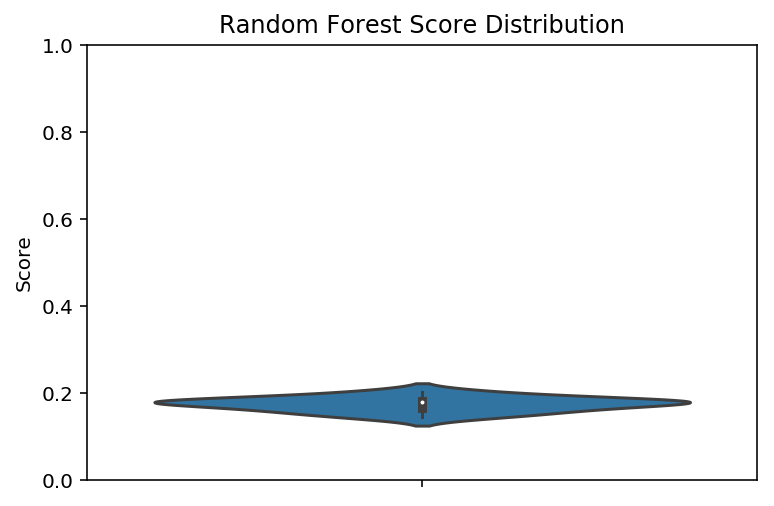

In [82]:
_ = sns.violinplot(scores, orient="v")
_ = plt.ylim(0.0, 1.0)
_ = plt.title("Random Forest Score Distribution")
_ = plt.ylabel("Score")

Unfortunately, the random forest was not able to accurately predict year of fire from the features we provided. As a future project you could perform [parameter tuning](https://scikit-learn.org/stable/modules/grid_search.html) or try a [different classifier](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html), and these scores may improve.

### 5.2 Multiple Regression

Here, we will try to perform regression using multiple features.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

We will use a [random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to try to predict the Fire Radiative Power from our other variables.

We will again need to clean up our input array and remove rows with NaN feature values.

In [4]:
feature_columns = [
    'fire_group_size',
    'dayofyear_start',
    'dayofyear_end',
    'vpd_mean',
    'temp_mean',
    'humidity_mean',
    'drought_length',
    'AWND_mean',
    'AWND_min',
    'AWND_max',
    'WSF2_mean',
    'WSF2_min',
    'WSF2_max',
    'WSF5_mean',
    'WSF5_min',
    'WSF5_max',
    'WT03_sum',
    'WT07_sum',
    'WT08_sum',
    'WT11_sum',
    'WT16_sum'
]
response_column = 'frp_mean'
regression_columns = feature_columns + [response_column]

regression_df = grouped_df[regression_columns].loc[pd.notnull(grouped_df[feature_columns]).all(axis=1)]

num_rows = grouped_df.shape[0]
num_na = grouped_df[feature_columns].loc[pd.isnull(grouped_df[feature_columns]).any(axis=1)].shape[0]
num_not_na = regression_df.shape[0]

print("Number of Rows with NaN:\t%i" % num_na)
print("Number of Rows without NaN:\t%i" % num_not_na)
print("Total Number of Rows:\t\t%i" % num_rows)

Number of Rows with NaN:	396
Number of Rows without NaN:	5674
Total Number of Rows:		6070


We will create our `X` and `y` arrays.

In [5]:
X = regression_df[feature_columns].values
y = regression_df[response_column].values

In [13]:
kf = KFold(n_splits=5, random_state=0)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))

scores

[0.056725542649194494,
 0.17410327679783885,
 0.18380343062911841,
 0.14027391740591344,
 0.14880715717893866]

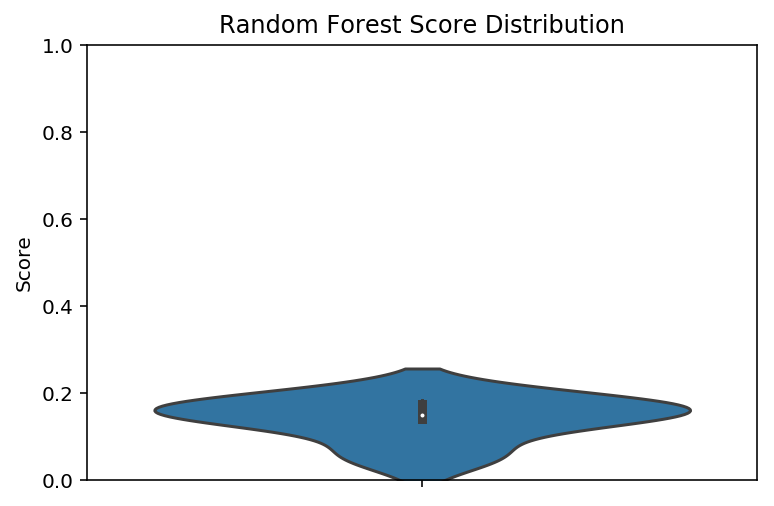

In [17]:
_ = sns.violinplot(scores, orient="v")
_ = plt.ylim(0.0, 1.0)
_ = plt.title("Random Forest Score Distribution")
_ = plt.ylabel("Score")

## 6. Conclusions

Unfortunately, all of this analysis has not really resulted in many new insights or inferences we can make about wildfires and the relationship to weather. Our initial regression and classification results were very poor.  Perhaps if the fire data had spanned a longer period of time we would have been able to see trends more clearly.  Or instead there might be inherent limitations in the fact that the wildfire data is derived from satellite imagery. Or the takeaway might simply be that there is no relationship between fires and weather.

But our analysis does support the idea that, at least for the west coast of the United States, wildfires occur spontaneously and from human activity such as [machinery sparks, cigarette butts, or arson](https://en.wikipedia.org/wiki/Wildfire#Causes).

And regardless of the results, this tutorial has demonstrated the data lifecycle:

<img src="img/data_lifecycle.png" alt="Data Lifecycle" width="500"/>